In [138]:
# import pyro
# import torch
# import torch.tensor as tensor
# import pyro.distributions as dist
# # from torch.distributions import Binomial, Gamma, Uniform
# from pyro.distributions import Binomial, Bernoulli, Categorical, Dirichlet, DirichletMultinomial, Beta, BetaBinomial, Uniform, Gamma, Multinomial

import numpy as np

import scipy
from skopt import gp_minimize 
from scipy.stats import binom as ScipyBinom
from matplotlib import pyplot
import torch
from torch import tensor

from collections import namedtuple
import time

seed = 0

In [139]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
from mvl import genData, likelihoods, bayes, popgen
from mvl.likelihoods import getAlphas, getPis

In [ ]:
# import copy
# resSim = {
#         "allRes": None,
#         "nEpochs": None,
#         "bestRes": {
#             "pis": None,
#             "alphas": None,
#             "PDV_c1true": None,
#             "PDV_c2true": None,
#             "PDV_cBothTrue": None,
#             "PDV_c1inferred": None,
#             "PDV_c2inferred": None,
#             "PDV_cBothInferred": None,
#         }
#     }

# cached6NormalSimResNonAnnealing = []

# rrsSim = tensor([[2, 2, 1.5]])
# pisSim = tensor([[.05, .05, .05]])

# nCases = tensor([15e3, 15e3, 6e3])
# nCtrls = tensor(5e5)
# i = 0
# for rrsSimRun in rrsSim:
#     for pisSimRun in pisSim:
#         afMeanRun = 1e-4
#         generatingFn = genData.v6normal
#         # In DSB:
#         # 	No ID	ID	
#         #         ASD+ADHD	684	217	
#         #         ASD	3091	871	
#         #         ADHD	3206	271	
#         #         Control	5002	-	

#         #         gnomAD	44779	(Non-Finnish Europeans in non-psychiatric exome subset)	

#         #         Case total:	8340		
#         #         Control total:	49781		
#         # so we can use pDBoth = .1 * total_cases
#         # needs tensor for shapes, otherwise "gamma_cpu not implemente for long", e.g rrShape=50.0 doesn't work...
#         paramsRun = genData.genParams(rrMeans=rrsSimRun, pis=pisSimRun, afMean=afMeanRun, rrShape=tensor(50.), afShape=tensor(50.), nCases=nCases, nCtrls=nCtrls)[0]
        
#         pDsRun = paramsRun["pDs"]
#         pisRun = paramsRun["diseaseFractions"]
#         print("params are:", paramsRun)
        
#         cached6NormalSimResNonAnnealing.append({"params": paramsRun, "runs": []})
#         for y in range(0, 10):
#             start = time.time()
#             r = generatingFn(**paramsRun)
#             print("took", time.time() - start)
            
#             resPointer = {
#                 **r,
#                 "generatingFn": generatingFn,
#                 "results": None,
#             }

#             cached6NormalSimResNonAnnealing[i]["runs"].append(resPointer)
            
#             print(f"Run: {i}, {y}")
            
#             xsRun = resPointer["altCounts"]
#             afsRun = resPointer["afs"]
#             affectedGenesRun = resPointer["affectedGenes"]
#             unaffectedGenesRun = resPointer["unaffectedGenes"]

#             runCostFnIdx = 16

#             nEpochsRun = 10
#             print("nEpochsRun", nEpochsRun)
            
#             res = likelihoods.fitFnBivariate(xsRun, pDsRun, nEpochs=nEpochsRun, minLLThresholdCount=20, debug=True, costFnIdx=runCostFnIdx)
#             bestRes = res["params"][-1]

#             inferredPis = tensor(bestRes[0:3]) # 3-vector
#             inferredAlphas = tensor(bestRes[3:]) # 4-vector, idx0 is P(!D|V)

#             #### Calculate actual ###
#             component1Afs = afsRun[affectedGenesRun[0]]
#             c1true = (component1Afs / afMeanRun).mean(0)

#             component2Afs = afsRun[affectedGenesRun[1]]
#             c2true = (component2Afs / afMeanRun).mean(0)

#             componentBothAfs = afsRun[affectedGenesRun[2]]
#             cBothTrue = (componentBothAfs / afMeanRun).mean(0)

#             ### calculate inferred values
#             pds = tensor([1-pDsRun.sum(), *pDsRun])
#             alphas = inferredAlphas.numpy()
#             c1inferred = Dirichlet(tensor([alphas[0], alphas[1], alphas[0], alphas[2]]) * pds).sample([10_000]).mean(0)
#             c2inferred = Dirichlet(tensor([alphas[0], alphas[0], alphas[2], alphas[2]]) * pds).sample([10_000]).mean(0)
#             cBothInferred = Dirichlet(tensor([alphas[0], (alphas[1] + alphas[3]), (alphas[2] + alphas[3]), (alphas[1] + alphas[2] + alphas[3])]) * pds).sample([10_000]).mean(0)

#             print(f"\n\nrun {i} results for rrs: {rrsSimRun}, pis: {pisSimRun}")
#             print("Inferred pis:", inferredPis)
#             print("\nP(D|V) true ans in component 1:", c1true)
#             print("P(D|V) inferred in component 1:", c1inferred)
#             print("\nP(D|V) true ans in component 1:", c2true)
#             print("P(D|V) inferred in component both:", c2inferred)
#             print("\nP(D|V) true ans in component both:", cBothTrue)
#             print("P(D|V) inferred in component both:", cBothInferred,"\n\n")

#             resToStore = copy.deepcopy(resSim)
#             resToStore["allRes"] = res
#             resToStore["nEpochs"] = nEpochsRun
#             br = resToStore["bestRes"]
#             br["pis"] = inferredPis
#             br["alphas"] = inferredAlphas
#             br["PDV_c1true"] = c1true
#             br["PDV_c2true"] = c2true
#             br["PDV_cBothTrue"] = cBothTrue
#             br["PDV_c1inferred"] = c1inferred
#             br["PDV_c2inferred"] = c2inferred
#             br["PDV_cBothInferred"] = cBothInferred

#             resPointer["results"] = resToStore
        
#         i += 1

In [4]:
# import copy
# resSim = {
#         "allRes": None,
#         "nEpochs": None,
#         "bestRes": {
#             "pis": None,
#             "alphas": None,
#             "PDV_c1true": None,
#             "PDV_c2true": None,
#             "PDV_cBothTrue": None,
#             "PDV_c1inferred": None,
#             "PDV_c2inferred": None,
#             "PDV_cBothInferred": None,
#         }
#     }

# cached6NormalSimRes = []

# rrsSim = tensor([[2, 2, 1.5]])
# pisSim = tensor([[.05, .05, .05]])

# nCases = tensor([15e3, 15e3, 6e3])
# nCtrls = tensor(5e5)
# i = 0
# for rrsSimRun in rrsSim:
#     for pisSimRun in pisSim:
#         afMeanRun = 1e-4
#         generatingFn = genData.v6normal
#         # In DSB:
#         # 	No ID	ID	
#         #         ASD+ADHD	684	217	
#         #         ASD	3091	871	
#         #         ADHD	3206	271	
#         #         Control	5002	-	

#         #         gnomAD	44779	(Non-Finnish Europeans in non-psychiatric exome subset)	

#         #         Case total:	8340		
#         #         Control total:	49781		
#         # so we can use pDBoth = .1 * total_cases
#         # needs tensor for shapes, otherwise "gamma_cpu not implemente for long", e.g rrShape=50.0 doesn't work...
#         paramsRun = genData.genParams(rrMeans=rrsSimRun, pis=pisSimRun, afMean=afMeanRun, rrShape=tensor(50.), afShape=tensor(50.), nCases=nCases, nCtrls=nCtrls)[0]
        
#         pDsRun = paramsRun["pDs"]
#         pisRun = paramsRun["diseaseFractions"]
#         print("params are:", paramsRun)
        
#         cached6NormalSimRes.append({"params": paramsRun, "runs": []})
#         for y in range(0, 10):
#             start = time.time()
#             r = generatingFn(**paramsRun)
#             print("took", time.time() - start)
            
#             resPointer = {
#                 **r,
#                 "generatingFn": generatingFn,
#                 "results": None,
#             }

#             cached6NormalSimRes[i]["runs"].append(resPointer)
            
#             print(f"Run: {i}, {y}")
            
#             xsRun = resPointer["altCounts"]
#             afsRun = resPointer["afs"]
#             affectedGenesRun = resPointer["affectedGenes"]
#             unaffectedGenesRun = resPointer["unaffectedGenes"]

#             runCostFnIdx = 16

#             nEpochsRun = 10
#             print("nEpochsRun", nEpochsRun)
            
#             res = likelihoods.fitFnBivariateAnnealing(xsRun, pDsRun, nEpochs=nEpochsRun, minLLThresholdCount=20, debug=True, costFnIdx=runCostFnIdx)
#             bestRes = res["params"][-1]

#             inferredPis = tensor(bestRes[0:3]) # 3-vector
#             inferredAlphas = tensor(bestRes[3:]) # 4-vector, idx0 is P(!D|V)

#             #### Calculate actual ###
#             component1Afs = afsRun[affectedGenesRun[0]]
#             c1true = (component1Afs / afMeanRun).mean(0)

#             component2Afs = afsRun[affectedGenesRun[1]]
#             c2true = (component2Afs / afMeanRun).mean(0)

#             componentBothAfs = afsRun[affectedGenesRun[2]]
#             cBothTrue = (componentBothAfs / afMeanRun).mean(0)

#             ### calculate inferred values
#             pds = tensor([1-pDsRun.sum(), *pDsRun])
#             alphas = inferredAlphas.numpy()
#             c1inferred = Dirichlet(tensor([alphas[0], alphas[1], alphas[0], alphas[2]]) * pds).sample([10_000]).mean(0)
#             c2inferred = Dirichlet(tensor([alphas[0], alphas[0], alphas[2], alphas[2]]) * pds).sample([10_000]).mean(0)
#             cBothInferred = Dirichlet(tensor([alphas[0], (alphas[1] + alphas[3]), (alphas[2] + alphas[3]), (alphas[1] + alphas[2] + alphas[3])]) * pds).sample([10_000]).mean(0)

#             print(f"\n\nrun {i} results for rrs: {rrsSimRun}, pis: {pisSimRun}")
#             print("Inferred pis:", inferredPis)
#             print("\nP(D|V) true ans in component 1:", c1true)
#             print("P(D|V) inferred in component 1:", c1inferred)
#             print("\nP(D|V) true ans in component 1:", c2true)
#             print("P(D|V) inferred in component both:", c2inferred)
#             print("\nP(D|V) true ans in component both:", cBothTrue)
#             print("P(D|V) inferred in component both:", cBothInferred,"\n\n")

#             resToStore = copy.deepcopy(resSim)
#             resToStore["allRes"] = res
#             resToStore["nEpochs"] = nEpochsRun
#             br = resToStore["bestRes"]
#             br["pis"] = inferredPis
#             br["alphas"] = inferredAlphas
#             br["PDV_c1true"] = c1true
#             br["PDV_c2true"] = c2true
#             br["PDV_cBothTrue"] = 
# cBothTrue
#             br["PDV_c1inferred"] = c1inferred
#             br["PDV_c2inferred"] = c2inferred
#             br["PDV_cBothInferred"] = cBothInferred

#             resPointer["results"] = resToStore
        
#         i += 1

pDs are: tensor([0.0280, 0.0280, 0.0112])
covShared is tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
params are: {'nGenes': 20000, 'nCases': tensor([15000., 15000.,  6000.]), 'nCtrls': tensor(500000.), 'pDs': tensor([0.0280, 0.0280, 0.0112]), 'diseaseFractions': tensor([0.0500, 0.0500, 0.0500]), 'rrShape': tensor(50.), 'rrMeans': tensor([2.0000, 2.0000, 1.5000]), 'afShape': tensor(50.), 'afMean': 0.0001, 'covShared': tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]), 'covSingle': tensor([[1, 0],
        [0, 1]])}
TESTING WITH: nCases tensor([15000., 15000.,  6000.]) nCtrls tensor(500000.) rrMeans tensor([2.0000, 2.0000, 1.5000]) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0280, 0.0280, 0.0112]) covShared tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]) covSingle tensor([[1, 0],
        [0, 1]])


test tensor 1,0,0,0,1,0,0,0,1
rrsShared tensor([[1.9565, 2.7884, 6.4489],
        [2.1411, 4.0445, 6.0811],
 

KeyboardInterrupt: 

In [5]:
# runSim()

NameError: name 'runSim' is not defined

In [ ]:
# runSim(fitMethod='nelder-mead')

In [ ]:
# res = np.load("./mvln-sim-mvln.npy", allow_pickle=True)

In [ ]:
# resByParams = []
# for runSet in res:
#     params = (runSet["params"]["diseaseFractions"], runSet["params"]["rrMeans"], runSet["params"]["rrShape"])
# #     print("param", params)
#     res = []
# #     if params not in resByParam:
# #         resByParams[params] = []
    
#     for run in runSet["runs"]:
#         if run is None or "results" not in run or run["results"] is None:
#             print(f"no results found for {params}")
#             continue
#         res.append(run["results"])
#     resByParams.append([params, res])

# np.save("mvln-sim-mvln-results2", resByParams)


In [27]:
resByParams = np.load("mvln-sim-mvln-results.npy", allow_pickle=True)
resByParams

In [ ]:
with open('./mvln-sim-mvn.json', 'w') as outfile:
    json.dump(cached6NormalSimRes, outfile)

In [ ]:
pool_size = multiprocessing.cpu_count()
os.system('taskset -cp 0-%d %s' % (pool_size, os.getpid()))

genData.runSim(fitMethod="nelder-mead", mt=True)

In [4]:
import os
os.system('taskset -p %s' %os.getpid())

32512

In [ ]:
# import torch 
# import pyro
# from torch.multiprocessing import Process
# from torch.distributions import Uniform
# import time
# import numpy as np
# def writer():
#     message = f"I am Process {i}"
#     print(torch.utils.data.get_worker_info())
#     x = np.random.seed()
#     x = np.random.randint(1000)
#     print('seed', x)
#     torch.manual_seed(x)
#     pis = Uniform(1/100, .5).rsample([3])
#     print("r is", pis)
#     time.sleep(1)

# def reader(i,q):
#     message = q.get()
#     print("got message", message)

# for i in range(10):
   
#     Process(target=writer, args=()).start()
#     time.sleep(.5)
#    # Create multiprocessing pool
#     p = Pool(10)
#    # Create a group of parallel readers and start them
#    # Number of readers is matching the number of writers
#    # However, the number of simultaneously running
#    # readers is constrained to the pool size
#     readers = []
#     for i in range(10):
#         readers.append(p.apply_async(reader, (i,q,)))
#     # Wait for the asynchrounous reader threads to finish
#     [r.get() for r in readers]
    
    
#     # Establish communication queues
#     tasks = torch.multiprocessing.JoinableQueue()
#     results = torch.multiprocessing.Queue()
    
#     # Start consumers
#     num_consumers = torch.multiprocessing.cpu_count()
#     print('Creating %d consumers' % num_consumers)
#     consumers = [ Consumer(tasks, results)
#                   for i in range(num_consumers) ]
#     for w in consumers:
#         w.start()
    
#     # Enqueue jobs
#     for i in range(nEpochs):
#         tasks.put(Task(altCountsByGene, pDs, 1, minLLThresholdCount, K, debug, costFnIdx, method))
    
#     # Add a poison pill for each consumer
#     for i in range(nEpochs):
#         tasks.put(None)

#     # Wait for all of the tasks to finish
#     tasks.join()
    
#     # Start printing results
#     while nEpochs:
#         result = results.get()
#         print('Result:', result)
#         num_jobs -= 1


In [ ]:
# genData.runSim(fitMethod="nelder-mead", mt=True)

In [133]:
rrs = tensor([3, 3, 1.5])
pis = tensor([.05, .05, .05])
nCases = tensor([10e3, 10e3, 4e3])
nCtrls = tensor(3e5)
afMean = 1e-4
rrShape=tensor(50.)
afShape=tensor(50.)
generatingFn =  genData.v6
fitMethod = 'nelder-mead'
nEpochs=20
mt = True
covShared=tensor([[1,.4,.4], [.4, 1, .4], [.4, .4, 1]])
covSingle=tensor([[1, 0], [0, 1]])
pDs=tensor([.01, .01, .005])

try:
    params = genData.genParams(rrMeans=rrs, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrls, covShared=covShared, covSingle=covSingle, pDs=pDs)[0]
    testData = generatingFn(**params)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0100, 0.0100, 0.0050])
covShared is tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(300000.) rrMeans tensor([3.0000, 3.0000, 1.5000]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0100, 0.0100, 0.0050])
rrDist mean tensor([2.9977, 2.9928, 1.5010])
startIndices [0, tensor(1000.), tensor(2000.)] endIndices tensor([1000., 2000., 3000.])
totalSamples 324000


In [6]:
nCtrlsSmall = tensor(5e4)

try:
    paramsSmall = genData.genParams(rrMeans=rrs, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrlsSmall, covShared=covShared, covSingle=covSingle, pDs=pDs)[0]
    testDataSmall = generatingFn(**paramsSmall)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0100, 0.0100, 0.0050])
covShared is tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(50000.) rrMeans tensor([3.0000, 3.0000, 1.5000]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0100, 0.0100, 0.0050])
rrDist mean tensor([2.9940, 2.9970, 1.5039])
startIndices [0, tensor(1000.), tensor(2000.)] endIndices tensor([1000., 2000., 3000.])
totalSamples 74000


In [134]:
testFit = likelihoods.fitFnBivariate(testData["altCounts"], params["pDs"], nEpochs=1)

torch.Size([20000, 4])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[34.,  1.,  1.,  0.],
        [25.,  0.,  0.,  0.],
        [35.,  1.,  0.,  0.],
        ...,
        [35.,  0.,  1.,  0.],
        [33.,  0.,  1.,  0.],
        [33.,  0.,  0.,  0.]])
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7feb692db050>
best ll: 45563.72756406394, bestParams: [0.010857601, 0.0404592, 0.10374962, 9933.877, 10387.52, 23429.746, 21704.621]
Epoch took 98.39441299438477


Params: tensor([ 3722574.8829, 11812879.9930, 12710937.8719,  7379405.2092],
       dtype=torch.float64) tensor([0.0448, 0.0594, 0.0470], dtype=torch.float64) tensor([10000., 10000.,  4000.]) tensor(300000.) 0.0001 tensor([0.0100, 0.0100, 0.0050]) tensor([50000])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        ...,
        [30.,  0.,  1.,  1.],
        [30.,  1.,  1.,  0.],
        [30.,  0.,  2.,  0.]])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050])
altCounts are tensor([[32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        ...,
        [30.,  0.,  1.,  1.],
        [30.,  1.,  1.,  0.],
        [30.,  0.,  2.,  0.]])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[34.,  1.,  1.,  0.],
        [25.,  0.,  0.,  0.],
        [35.,  1.,  0.,  0.],
        ...,
        [35., 

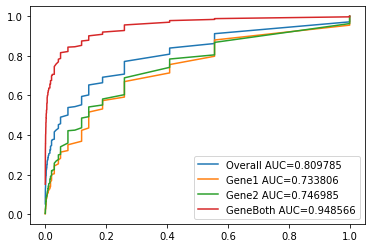

In [146]:
bayes.aucROC(testFit, testData, params, "test-full-posterior.png")

Params: tensor([ 3722574.8829, 11812879.9930, 12710937.8719,  7379405.2092],
       dtype=torch.float64) tensor([0.2500, 0.2500, 0.2500]) tensor([10000., 10000.,  4000.]) tensor(300000.) 0.0001 tensor([0.0100, 0.0100, 0.0050]) tensor([50000])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        ...,
        [32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        [31.,  0.,  0.,  1.]])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050])
altCounts are tensor([[32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        ...,
        [32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        [31.,  0.,  0.,  1.]])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[34.,  1.,  1.,  0.],
        [25.,  0.,  0.,  0.],
        [35.,  1.,  0.,  0.],
        ...,
        [35.,  0.,  1.,  0.],
     

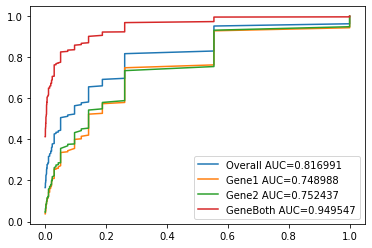

In [148]:
bayes.aucROCflatPrior(testFit, testData, params, "test-full-posterior.png")

In [12]:
pisUnbalanced = tensor([.1, .05, .02])

try:
    paramsUnbalanced = genData.genParams(rrMeans=rrs, pis=pisUnbalanced, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrlsSmall, covShared=covShared, covSingle=covSingle, pDs=pDs)[0]
    testDataUnbalanced = generatingFn(**paramsUnbalanced)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0100, 0.0100, 0.0050])
covShared is tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(50000.) rrMeans tensor([3.0000, 3.0000, 1.5000]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.1000, 0.0500, 0.0200]) pDs tensor([0.0100, 0.0100, 0.0050])
rrDist mean tensor([3.0027, 2.9970, 1.5022])
startIndices [0, tensor(2000.), tensor(3000.)] endIndices tensor([2000., 3000., 3400.])
totalSamples 74000


In [15]:
paramsUnbalanced

{'nGenes': 20000,
 'nCases': tensor([10000., 10000.,  4000.]),
 'nCtrls': tensor(50000.),
 'pDs': tensor([0.0100, 0.0100, 0.0050]),
 'diseaseFractions': tensor([0.1000, 0.0500, 0.0200]),
 'rrShape': tensor(50.),
 'rrMeans': tensor([3.0000, 3.0000, 1.5000]),
 'afShape': tensor(50.),
 'afMean': 0.0001,
 'covShared': tensor([[1.0000, 0.4000, 0.4000],
         [0.4000, 1.0000, 0.4000],
         [0.4000, 0.4000, 1.0000]]),
 'covSingle': tensor([[1, 0],
         [0, 1]])}

In [13]:
testFitUnbalanced = likelihoods.fitFnBivariate(testDataUnbalanced["altCounts"], paramsUnbalanced["pDs"], nEpochs=1)

torch.Size([20000, 4])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[7., 1., 0., 0.],
        [7., 0., 0., 0.],
        [7., 0., 0., 0.],
        ...,
        [7., 0., 1., 0.],
        [8., 0., 0., 0.],
        [9., 0., 0., 0.]])
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7feb41f97b90>
best ll: 15402.448939067956, bestParams: [0.28427178, 0.1498136, 0.15833865, 10361.806, 8405.314, 8169.8916, 17429.117]
Epoch took 96.11048173904419


In [14]:
testFitUnbalanced["params"]

[array([5.98922212e-01, 1.45205658e-01, 2.49854854e-01, 2.77749644e+02,
        2.51366856e+02, 1.74848841e+02, 3.62809433e+02])]

In [19]:
likelihoods.trueVsEst(testFitUnbalanced, testDataUnbalanced, paramsUnbalanced)

est pis: [0.59892221 0.14520566 0.24985485]
tru pis: tensor([0.1000, 0.0500, 0.0200])


Estimate for component: 0
est: P(D|V) [0.9777399  0.00907556 0.0100281  0.00315644] variance: [7.82979604e-05 3.23529405e-05 3.57142540e-05 1.13194408e-05] alphas: [0.9777399  0.00907556 0.0100281  0.00315644]
tru: P(D|V) [0.94440615 0.02987938 0.00999216 0.01493969] alphas: [0.94440615 0.02987938 0.00999216 0.01493969]


Estimate for component: 1
est: P(D|V) [0.98044856 0.01005588 0.00633037 0.00316519] variance: [6.91513739e-05 3.59110424e-05 2.26917815e-05 1.13820314e-05] alphas: [0.98044856 0.01005588 0.00633037 0.00316519]
tru: P(D|V) [0.94558364 0.01000551 0.02997452 0.01498726] alphas: [0.94558364 0.01000551 0.02997452 0.01498726]


Estimate for component: 2
est: P(D|V) [0.9459828  0.02145449 0.01878155 0.01378116] variance: [1.77879535e-04 7.30819000e-05 6.41516444e-05 4.73118452e-05] alphas: [0.9459828  0.02145449 0.01878155 0.01378116]
tru: P(D|V) [0.8657395  0.04463167 0.04418266 0.037017

((tensor([0.9777, 0.0091, 0.0100, 0.0032], dtype=torch.float64),
  tensor([0.9804, 0.0101, 0.0063, 0.0032], dtype=torch.float64),
  tensor([0.9460, 0.0215, 0.0188, 0.0138], dtype=torch.float64)),
 (tensor([7.8298e-05, 3.2353e-05, 3.5714e-05, 1.1319e-05], dtype=torch.float64),
  tensor([6.9151e-05, 3.5911e-05, 2.2692e-05, 1.1382e-05], dtype=torch.float64),
  tensor([1.7788e-04, 7.3082e-05, 6.4152e-05, 4.7312e-05], dtype=torch.float64)),
 (tensor([0.9444, 0.0299, 0.0100, 0.0149]),
  tensor([0.9456, 0.0100, 0.0300, 0.0150]),
  tensor([0.8657, 0.0446, 0.0442, 0.0370])))

In [8]:
try:
    paramsSmallUnbalanced = genData.genParams(rrMeans=rrs, pis=pisUnbalanced, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrlsSmall, covShared=covShared, covSingle=covSingle, pDs=pDs)[0]
    testDataSmallUnbalanced = generatingFn(**paramsSmallUnbalanced)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0100, 0.0100, 0.0050])
covShared is tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(50000.) rrMeans tensor([3.0000, 3.0000, 1.5000]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0700, 0.0100]) pDs tensor([0.0100, 0.0100, 0.0050])
rrDist mean tensor([2.9933, 3.0003, 1.4971])
startIndices [0, tensor(1000.), tensor(2400.)] endIndices tensor([1000., 2400., 2600.])
totalSamples 74000


In [6]:
testDataSmall["altCounts"][testDataSmall["affectedGenes"][0]].mean(0)

tensor([6.5460, 0.1960, 0.0590, 0.0970])

In [7]:
testFitSmall = likelihoods.fitFnBivariate(testDataSmall["altCounts"], paramsSmall["pDs"], nEpochs=1)

torch.Size([20000, 4])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[4., 1., 0., 0.],
        [6., 0., 0., 0.],
        [8., 0., 0., 0.],
        ...,
        [7., 0., 0., 0.],
        [8., 1., 0., 0.],
        [7., 0., 0., 0.]])
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7feb494c4cb0>
best ll: 16578.048790746383, bestParams: [0.07810017, 0.08376963, 0.03631915, 5288.862, 13578.524, 18612.941, 10178.6875]
Epoch took 138.46251392364502


In [9]:
testDataSmallUnbalanced["altCounts"][testDataSmallUnbalanced["affectedGenes"][0]].mean(0)

tensor([6.5160, 0.2290, 0.0750, 0.1010])

In [217]:
# rrs2component = tensor([3, 3, 0])
# pDs2Component = tensor([.01, .01, .005])

# try:
#     paramsSmall2component = genData.genParams(rrMeans=rrs2component, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrlsSmall, covShared=covShared, covSingle=covSingle, pDs=pDs2Component)[0]
#     testDataSmall2component= generatingFn(**paramsSmall2component)
# except Exception as e:
#     print(f"Run failed: {e}")

pDs are: tensor([0.0100, 0.0100, 0.0050])
covShared is tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(50000.) rrMeans tensor([3, 3, 0]) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0411, 0.0450, 0.0521], dtype=torch.float64) pDs tensor([0.0100, 0.0100, 0.0050]) covShared tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]]) covSingle tensor([[1, 0],
        [0, 1]])


test tensor 1.0,0.4,0.4,0.4,1.0,0.4,0.4,0.4,1.0
rrsShared tensor([[3.2922, 4.3945, 7.6409],
        [4.1917, 4.5638, 7.9649],
        [3.3563, 5.1530, 7.3710],
        ...,
        [2.3117, 2.7856, 5.5439],
        [1.7110, 3.1120, 5.5781],
        [3.0423, 2.6757, 5.4800]], dtype=torch.float64) means tensor([3.0712, 3.0766, 6.0342], dtype=torch.float64)
rrShared correlation 1 & 2 [[1.         0.36476258]
 [0.36476258 1.        ]]
rrSha

In [10]:
testFitSmallUnbalanced = likelihoods.fitFnBivariate(testDataSmallUnbalanced["altCounts"], paramsSmallUnbalanced["pDs"], nEpochs=1)

torch.Size([20000, 4])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[7., 1., 0., 0.],
        [6., 1., 0., 0.],
        [5., 0., 0., 0.],
        ...,
        [7., 0., 0., 0.],
        [6., 0., 0., 0.],
        [6., 0., 0., 0.]])
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7feb38ff43b0>
best ll: 15094.808911948272, bestParams: [0.15388641, 0.11372052, 0.2616223, 15993.872, 5205.243, 9199.959, 24293.455]
Epoch took 158.34311604499817


In [11]:
testFitSmallUnbalanced["params"]

[array([1.90272630e-02, 1.50705322e-01, 1.51809508e-02, 8.16677559e+05,
        2.79102954e+06, 1.68928596e+06, 2.91205690e+06])]

In [23]:
rrsLarge = tensor([5, 5, 2])

try:
    paramsRRLarge = genData.genParams(rrMeans=rrsLarge, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrls, covShared=covShared, covSingle=covSingle, pDs=pDs)[0]
    testDataRRLarge = generatingFn(**paramsRRLarge)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0100, 0.0100, 0.0050])
covShared is tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(300000.) rrMeans tensor([5, 5, 2]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0100, 0.0100, 0.0050])
rrDist mean tensor([4.9996, 5.0045, 1.9934])
startIndices [0, tensor(1000.), tensor(2000.)] endIndices tensor([1000., 2000., 3000.])
totalSamples 324000


In [292]:
rrsWideRange = tensor([15, 5, 2])

try:
    paramsWideRR = genData.genParams(rrMeans=rrsWideRange, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrlsSmall, covShared=covShared, covSingle=covSingle, pDs=pDs)[0]
    testDataWideRR = generatingFn(**paramsWideRR)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0100, 0.0100, 0.0050])
covShared is tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(50000.) rrMeans tensor([15,  5,  2]) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0411, 0.0450, 0.0521], dtype=torch.float64) pDs tensor([0.0100, 0.0100, 0.0050]) covShared tensor([[1.0000, 0.4000, 0.4000],
        [0.4000, 1.0000, 0.4000],
        [0.4000, 0.4000, 1.0000]]) covSingle tensor([[1, 0],
        [0, 1]])


test tensor 1.0,0.4,0.4,0.4,1.0,0.4,0.4,0.4,1.0
rrsShared tensor([[16.7697,  5.6185, 21.8001],
        [16.4279,  7.6230, 22.2758],
        [16.5740,  5.9700, 21.3631],
        ...,
        [17.2670,  6.2274, 21.5251],
        [16.3213,  6.3124, 21.6979],
        [16.7531,  7.1473, 22.3798]], dtype=torch.float64) means tensor([17.0008,  6.9984, 22.0001], dtype=torch.float64)
rrShared correlation 1 & 2 [[1.         0.39905565]
 [0.399

In [ ]:
rrsLargeUnbalanced = tensor([5, 5, 2])

try:
    paramsRRLarge = genData.genParams(rrMeans=rrsLarge, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrls, covShared=covShared, covSingle=covSingle, pDs=pDs)[0]
    testDataRRLarge = generatingFn(**paramsRRLarge)
except Exception as e:
    print(f"Run failed: {e}")

In [24]:
testFitLargeRR = likelihoods.fitFnBivariate(testDataRRLarge["altCounts"], paramsRRLarge["pDs"], nEpochs=1)

torch.Size([20000, 4])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[33.,  0.,  0.,  0.],
        [26.,  0.,  0.,  1.],
        [29.,  3.,  0.,  1.],
        ...,
        [32.,  1.,  2.,  1.],
        [37.,  2.,  0.,  0.],
        [38.,  1.,  0.,  1.]])
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7feb593ffb00>
best ll: 49884.929121107314, bestParams: [0.06271392, 0.05280732, 0.057855126, 1587.1685, 3733.716, 9903.636, 9601.56]
Epoch took 55.160454988479614


4705882.2465117825, 14878116.551499803, 15375946.47884507, 8459123.541455561], [4705882.245760967, 14878116.54912599, 15375946.476391932, 8459123.5401059], [4705882.246913547, 14878116.552770086, 15375946.480157811, 8459123.542177698], [4705882.246347358, 14878116.550979862, 15375946.478307799, 8459123.541160136], [4705882.246408445, 14878116.551173162, 15375946.478507517, 8459123.541269673], [4705882.246700221, 14878116.552095538, 15375946.479460744, 8459123.541794367], [4705882.247469493, 14878116.554527799, 15375946.48197428, 8459123.543177044], [4705882.246035552, 14878116.549994137, 15375946.477289096, 8459123.540599477], [4705882.246066058, 14878116.550090574, 15375946.477388762, 8459123.540654326], [4705882.246777343, 14878116.55233945, 15375946.479712784, 8459123.54193287], [4705882.24619421, 14878116.550495781, 15375946.477807501, 8459123.540884642], [4705882.246729674, 14878116.552188713, 15375946.479557006, 8459123.541847218], [4705882.246513833, 14878116.551506374, 15375946

In [211]:
testFitSmall = likelihoods.fitFnBivariateMT(testDataSmall["altCounts"], paramsSmall["pDs"], nEpochs=1)

torch.Size([20000, 4])
pDS aretensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts aretensor([[8., 0., 0., 0.],
        [7., 0., 0., 0.],
        [6., 0., 0., 0.],
        ...,
        [7., 0., 0., 0.],
        [7., 0., 0., 0.],
        [7., 0., 0., 0.]], dtype=torch.float64)
methodnelder-meadcostFn<function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9759c303b0>
best ll: 16331.898099869932, bestParams: [0.13035114, 0.10482146, 0.032658506, 4894.5635, 8843.956, 16086.7, 24699.387]
Epoch took106.8223569393158


In [299]:
testDataSmall["altCounts"][0:000].mean(0)

tensor([6.4175, 0.1500, 0.1850, 0.1390], dtype=torch.float64)

In [283]:
pDgivenVestSmall, pDgivenVestVarSmall, truePDGivenVsmall = likelihoods.trueVsEst(testFitSmall[0], testDataSmall, paramsSmall)



Estimate for component: 0
est: pis [0.93998753 0.03174669 0.0096409  0.01862489] variance: [6.91037411e-08 3.76552364e-08 1.16962891e-08 2.23906458e-08] alphas: [0.93998753 0.03174669 0.0096409  0.01862489]
tru: pis [0.95100551 0.03008798 0.01006199 0.01504399] alphas: [0.95100551 0.03008798 0.01006199 0.01504399]


Estimate for component: 1
est: pis [0.93484301 0.00958813 0.03704591 0.01852295] variance: [7.42086027e-08 1.15692291e-08 4.34610634e-08 2.21485305e-08] alphas: [0.93484301 0.00958813 0.03704591 0.01852295]
tru: pis [0.93901051 0.00994923 0.0306425  0.01532125] alphas: [0.93901051 0.00994923 0.0306425  0.01532125]


Estimate for component: 2
est: pis [0.85327738 0.04992814 0.05492359 0.04187089] variance: [1.39217372e-07 5.27482428e-08 5.77207494e-08 4.46110369e-08] alphas: [0.85327738 0.04992814 0.05492359 0.04187089]
tru: pis [0.87194589 0.04555815 0.0450851  0.03762326] alphas: [0.87194589 0.04555815 0.0450851  0.03762326]


In [284]:
pDgivenVestSmall

(tensor([0.9400, 0.0317, 0.0096, 0.0186], dtype=torch.float64),
 tensor([0.9348, 0.0096, 0.0370, 0.0185], dtype=torch.float64),
 tensor([0.8533, 0.0499, 0.0549, 0.0419], dtype=torch.float64))

In [254]:
testDataSmall["afs"].mean(1)

tensor([2.8537e-05, 2.4044e-05, 2.1846e-05,  ..., 2.5248e-05, 2.6033e-05,
        2.5244e-05], dtype=torch.float64)

In [261]:
paramsSmall["pDs"]

tensor([0.0100, 0.0100, 0.0050])

In [281]:
pDgivenVestSmall

(tensor([0.9210, 0.0311, 0.0365, 0.0114], dtype=torch.float64),
 tensor([0.9210, 0.0311, 0.0365, 0.0114], dtype=torch.float64),
 tensor([0.8533, 0.0499, 0.0549, 0.0419], dtype=torch.float64))

In [289]:
testDataSmall["afs"][:, 1:].mean(1)

tensor([2.2445e-06, 1.5559e-06, 1.0177e-06,  ..., 8.4161e-07, 8.6777e-07,
        8.4145e-07], dtype=torch.float64)

In [273]:
Normal(0, 1).icdf(tensor([.1, .2, .3]))

tensor([-1.2816, -0.8416, -0.5244])

In [286]:
testDataSmall["afs"].shape

torch.Size([20000, 4])

In [ ]:
manualArgmax = tensor([pDgivenVestSmall[]

In [290]:
meanEffect, meanProtectiveEffect = popgen.liabilityFromRisk(pDgivenVestSmall[1:], paramsSmall["pDs"][0], testDataSmall["afs"][:, 1:])

tensor(-2.3263)


TypeError: unsupported operand type(s) for -: 'Tensor' and 'tuple'

In [301]:
testFitSmallUnbalanced = likelihoods.fitFnBivariate(testDataSmallUnbalanced["altCounts"], paramsSmallUnbalanced["pDs"], nEpochs=1)
testFitSmallUnbalanced

torch.Size([20000, 4])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[6., 0., 0., 0.],
        [8., 0., 0., 0.],
        [8., 0., 0., 0.],
        ...,
        [7., 0., 0., 0.],
        [5., 0., 0., 0.],
        [5., 0., 0., 0.]], dtype=torch.float64)
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f975a273710>
best ll: 14970.334457381228, bestParams: [0.050208744, 0.031480435, 0.024930885, 5686.31, 16122.359, 14841.158, 11966.893]
Epoch took 48.801963090896606


[array([3.90092322e-01, 1.25460663e-08, 1.20440275e-01, 1.35764402e+04,
        1.38149164e+04, 2.10073965e+04, 2.66834330e+04])]

In [27]:
testFit = testFit[0] #1 epoch

In [230]:
from pyro.distributions import HalfNormal, Normal
Normal(0,1).icdf(tensor(.9))

tensor(1.2816)

In [24]:
print("fuck you")

fuck you


In [9]:
testFitLarge = likelihoods.fitFnBivariateMT(testDataLarge["altCounts"], paramsLarge["pDs"], nEpochs=1)

torch.Size([20000, 4])
pDS aretensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts aretensor([[28.,  3.,  0.,  0.],
        [31.,  1.,  1.,  1.],
        [24.,  2.,  0.,  0.],
        ...,
        [32.,  0.,  0.,  1.],
        [24.,  2.,  0.,  0.],
        [27.,  1.,  0.,  0.]])
methodnelder-meadcostFn<function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9780c503b0>
best ll: 51748.645502753454, bestParams: [0.1065773, 0.08033894, 0.10394585, 3636.596, 14836.11, 10916.601, 18213.424]
Epoch took210.31504011154175


In [28]:
testFitLarge = testFitLarge[0]

In [29]:
testFit["params"]

[array([4.11474056e-02, 4.50024174e-02, 5.21064491e-02, 4.70588225e+06,
        1.48781166e+07, 1.53759465e+07, 8.45912354e+06])]

In [30]:
testFitLarge["params"]

[array([4.81536365e-02, 4.48564146e-02, 4.98845023e-02, 7.54315818e+06,
        4.19020039e+07, 4.48680030e+07, 6.19789450e+07])]

In [294]:
testFitWideRR = likelihoods.fitFnBivariate(testDataWideRR["altCounts"], paramsWideRR["pDs"], nEpochs=1)

torch.Size([20000, 4])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[5., 2., 0., 0.],
        [5., 1., 0., 1.],
        [7., 0., 0., 0.],
        ...,
        [7., 0., 0., 0.],
        [7., 0., 0., 0.],
        [6., 0., 0., 0.]], dtype=torch.float64)
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f97598f5710>
best ll: 22242.808726361312, bestParams: [0.10194511, 0.1501885, 0.07120221, 2169.7144, 22039.68, 4887.0444, 15310.189]
Epoch took 122.41097497940063


In [296]:
print(testFitWideRR["params"])
paramsWideRR

[array([2.67504597e-02, 2.90571557e-02, 6.34138225e-02, 2.24238976e+06,
       4.92334454e+07, 1.74097420e+07, 2.56162179e+06])]


{'nGenes': 20000,
 'nCases': tensor([10000., 10000.,  4000.]),
 'nCtrls': tensor(50000.),
 'pDs': tensor([0.0100, 0.0100, 0.0050]),
 'diseaseFractions': tensor([0.0411, 0.0450, 0.0521], dtype=torch.float64),
 'rrShape': tensor(50.),
 'rrMeans': tensor([15,  5,  2]),
 'afShape': tensor(50.),
 'afMean': 0.0001,
 'covShared': tensor([[1.0000, 0.4000, 0.4000],
         [0.4000, 1.0000, 0.4000],
         [0.4000, 0.4000, 1.0000]]),
 'covSingle': tensor([[1, 0],
         [0, 1]])}

In [31]:
ta = tensor(testFit["trajectoryAlphas"])

In [32]:
taLarge = tensor(testFitLarge["trajectoryAlphas"])

In [33]:
bestLL = None
bestParams = None
for x in testFit:
    if bestLL is None or x["lls"][0] < bestLL:
        bestParams = x["params"][0]
        bestLL = x["lls"][0]
    

TypeError: string indices must be integers

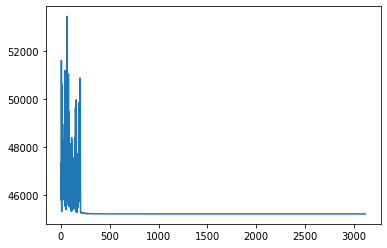

In [34]:
pyplot.plot(testFit["trajectoryLLs"])

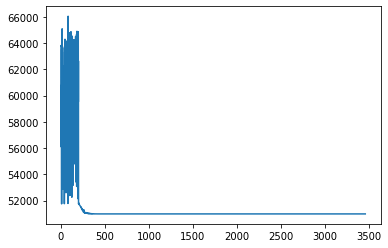

In [35]:
pyplot.plot(testFitLarge["trajectoryLLs"])

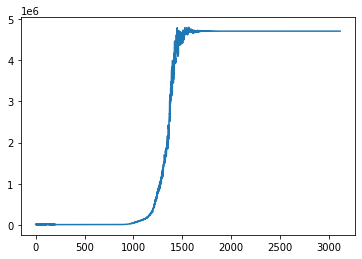

In [36]:
pyplot.plot(ta[:,0])

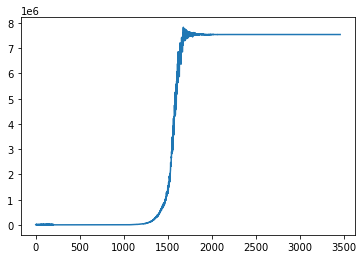

In [37]:
pyplot.plot(taLarge[:,0])

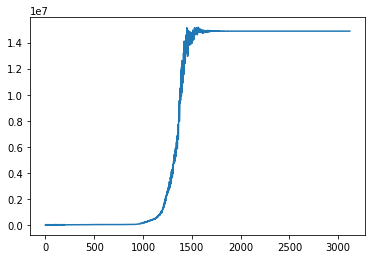

In [38]:
pyplot.plot(ta[:,1])

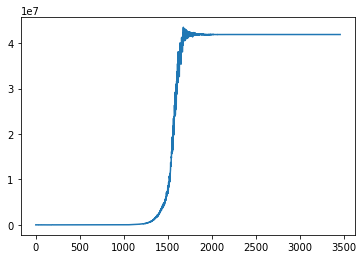

In [39]:
pyplot.plot(taLarge[:,1])

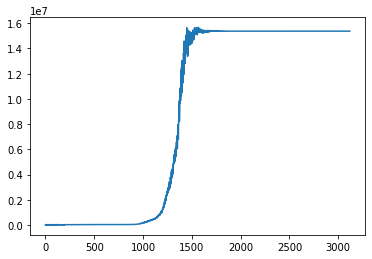

In [40]:
pyplot.plot(ta[:,2])

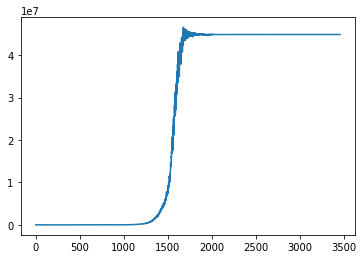

In [41]:
pyplot.plot(taLarge[:,2])

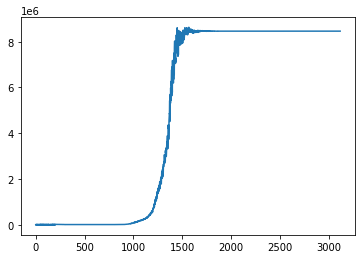

In [42]:
pyplot.plot(ta[:,3])

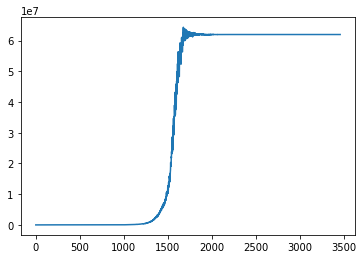

In [43]:
pyplot.plot(taLarge[:,3])

In [44]:
pisTraj = tensor(testFit["trajectoryPi"])


In [45]:
pisTrajLarge = tensor(testFitLarge["trajectoryPi"])

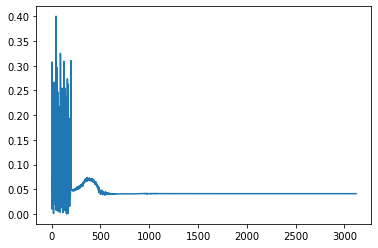

In [46]:
pyplot.plot(pisTraj[:,0])

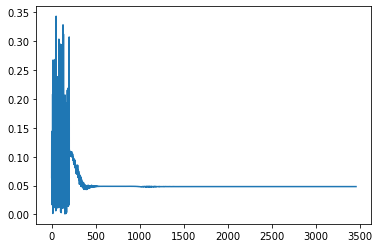

In [47]:
pyplot.plot(pisTrajLarge[:,0])

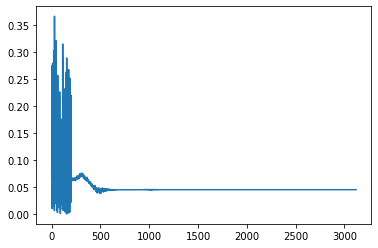

In [48]:
pyplot.plot(pisTraj[:,1])

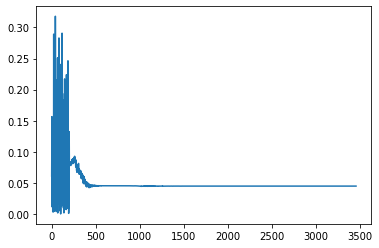

In [49]:
pyplot.plot(pisTrajLarge[:,1])

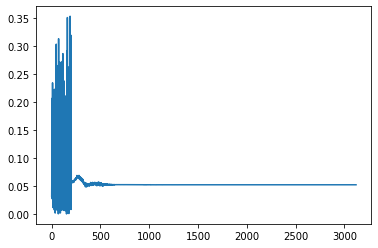

In [50]:
pyplot.plot(pisTraj[:,2])

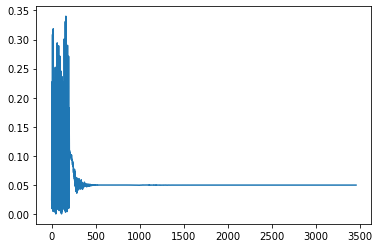

In [51]:
pyplot.plot(pisTrajLarge[:,2])

In [52]:
testCounts = testData["altCounts"]
testCountsLarge = testDataLarge["altCounts"]
testCountsLarge

tensor([[28.,  3.,  0.,  0.],
        [31.,  1.,  1.,  1.],
        [24.,  2.,  0.,  0.],
        ...,
        [32.,  0.,  0.,  1.],
        [24.,  2.,  0.,  0.],
        [27.,  1.,  0.,  0.]])

In [53]:
len(testDataLarge["affectedGenes"])

3

In [196]:
from torch.distributions import Dirichlet
a = tensor(testFitLarge["params"][0][3:])
pds = paramsLarge["pDs"]
Dirichlet(a * tensor([1-pds.sum(), *pds])).variance

tensor([1.3944e-08, 5.4733e-09, 5.8392e-09, 4.1023e-09], dtype=torch.float64)

In [242]:
pDgivenVestLarge, pDgivenVestVarLarge, truePDGivenVlarge = likelihoods.trueVsEst(testFitLarge, testDataLarge, paramsLarge)



Estimate for component: 0
est: pis [0.86198186 0.04911058 0.05258683 0.03632072] variance: [1.39435873e-08 5.47325047e-09 5.83924464e-09 4.10229813e-09] alphas: [0.86198186 0.04911058 0.05258683 0.03632072]
tru: pis [0.91405404 0.04971014 0.00998605 0.02485507] alphas: [0.91405404 0.04971014 0.00998605 0.02485507]


Estimate for component: 1
est: pis [0.86198186 0.04911058 0.05258683 0.03632072] variance: [1.39435873e-08 5.47325047e-09 5.83924464e-09 4.10229813e-09] alphas: [0.86198186 0.04911058 0.05258683 0.03632072]
tru: pis [0.9151905  0.01000655 0.05030494 0.02515247] alphas: [0.9151905  0.01000655 0.05030494 0.02515247]


Estimate for component: 2
est: pis [0.72064133 0.10178815 0.1046944  0.07287612] variance: [1.97261623e-08 8.95854108e-09 9.18451072e-09 6.62040089e-09] alphas: [0.72064133 0.10178815 0.1046944  0.07287612]
tru: pis [0.73221594 0.10122715 0.10162838 0.0760702 ] alphas: [0.73221594 0.10122715 0.10162838 0.0760702 ]


In [200]:
pDgivenVest, pDgivenVestVar, truePDGivenV = likelihoods.trueVsEst(testFit, testData, params)



Estimate for component: 0
est: pis [0.93009705 0.03015994 0.03116911 0.00857389] variance: [1.31797221e-08 5.92943275e-09 6.12145849e-09 1.72314093e-09] alphas: [0.93009705 0.03015994 0.03116911 0.00857389]
tru: pis [0.9487625  0.02990983 0.01003663 0.01495492] alphas: [0.9487625  0.02990983 0.01003663 0.01495492]


Estimate for component: 1
est: pis [0.93009705 0.03015994 0.03116911 0.00857389] variance: [1.31797221e-08 5.92943275e-09 6.12145849e-09 1.72314093e-09] alphas: [0.93009705 0.03015994 0.03116911 0.00857389]
tru: pis [0.9397148  0.0099441  0.02983442 0.01491721] alphas: [0.9397148  0.0099441  0.02983442 0.01491721]


Estimate for component: 2
est: pis [0.87336329 0.04442206 0.04536968 0.03684497] variance: [2.10525018e-08 8.08004949e-09 8.24422946e-09 6.75497174e-09] alphas: [0.87336329 0.04442206 0.04536968 0.03684497]
tru: pis [0.8721773  0.04512873 0.04507688 0.03762778] alphas: [0.8721773  0.04512873 0.04507688 0.03762778]


In [209]:
testData["altCounts"][testData["affectedGenes"][0]].mean(0)

tensor([30.3360,  0.8760,  0.3140,  0.4830])

In [160]:
pDgivenVest

(tensor([0.9439, 0.0306, 0.0097, 0.0158], dtype=torch.float64),
 tensor([0.9429, 0.0097, 0.0316, 0.0158], dtype=torch.float64),
 tensor([0.8734, 0.0444, 0.0454, 0.0368], dtype=torch.float64))

Params: tensor([ 7543158.1781, 41902003.9298, 44868002.9825, 61978944.9754],
       dtype=torch.float64) tensor([0.0482, 0.0449, 0.0499], dtype=torch.float64) tensor([10000., 10000.,  4000.]) tensor(300000.) 0.0001 tensor([0.0100, 0.0100, 0.0050]) tensor([50000])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        [31.,  1.,  0.,  0.],
        ...,
        [30.,  0.,  1.,  1.],
        [30.,  1.,  1.,  0.],
        [32.,  0.,  0.,  0.]])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050])
altCounts are tensor([[32.,  0.,  0.,  0.],
        [32.,  0.,  0.,  0.],
        [31.,  1.,  0.,  0.],
        ...,
        [30.,  0.,  1.,  1.],
        [30.,  1.,  1.,  0.],
        [32.,  0.,  0.,  0.]])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[28.,  3.,  0.,  0.],
        [31.,  1.,  1.,  1.],
        [24.,  2.,  0.,  0.],
        ...,
        [32., 

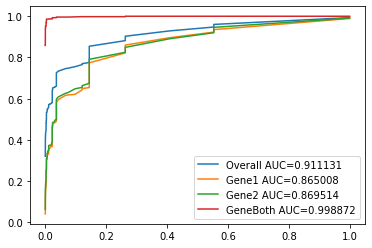

In [157]:
bayes.aucROC(testFitLarge, testDataLarge, paramsLarge, "test-large-flat-prior.png")

Params: tensor([ 7543158.1781, 41902003.9298, 44868002.9825, 61978944.9754],
       dtype=torch.float64) tensor([0.2500, 0.2500, 0.2500]) tensor([10000., 10000.,  4000.]) tensor(300000.) 0.0001 tensor([0.0100, 0.0100, 0.0050]) tensor([50000])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[30.,  1.,  1.,  0.],
        [31.,  1.,  0.,  0.],
        [30.,  0.,  1.,  1.],
        ...,
        [32.,  0.,  0.,  0.],
        [30.,  1.,  1.,  0.],
        [31.,  0.,  1.,  0.]])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050])
altCounts are tensor([[30.,  1.,  1.,  0.],
        [31.,  1.,  0.,  0.],
        [30.,  0.,  1.,  1.],
        ...,
        [32.,  0.,  0.,  0.],
        [30.,  1.,  1.,  0.],
        [31.,  0.,  1.,  0.]])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[28.,  3.,  0.,  0.],
        [31.,  1.,  1.,  1.],
        [24.,  2.,  0.,  0.],
        ...,
        [32.,  0.,  0.,  1.],
     

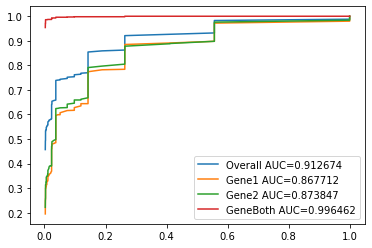

In [291]:
bayes.aucROCflatPrior(testFitLarge, testDataLarge, paramsLarge, "test-large-flat-prior.png")

In [71]:
h0, h1, h2, h3 = bayes.bfdpAlternates(altCounts=testDataLarge["altCounts"], pDs=paramsLarge["pDs"], alphas=tensor(testFitLarge["params"][0][3:]), pis=tensor(testFitLarge["params"][0][0:3]), nAlternateHypotheses=3)

print(testDataLarge["altCounts"])

print("h1/h0\n", (h1/h0)[0:100])
print("h1/h2\n", (h1/h2)[0:100])
print("h1/hBoth\n", (h1/h3)[0:100])

pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[28.,  3.,  0.,  0.],
        [31.,  1.,  1.,  1.],
        [24.,  2.,  0.,  0.],
        ...,
        [32.,  0.,  0.,  1.],
        [24.,  2.,  0.,  0.],
        [27.,  1.,  0.,  0.]])
pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050])
altCounts are tensor([[28.,  3.,  0.,  0.],
        [31.,  1.,  1.,  1.],
        [24.,  2.,  0.,  0.],
        ...,
        [32.,  0.,  0.,  1.],
        [24.,  2.,  0.,  0.],
        [27.,  1.,  0.,  0.]])
effects tensor([[2.3536e-03, 1.0784e-05, 2.4543e-05],
        [1.2863e-03, 1.1393e-03, 5.4027e-05],
        [4.7174e-03, 1.2342e-04, 6.4641e-05],
        ...,
        [2.2169e-03, 1.8439e-03, 3.3580e-06],
        [4.7174e-03, 1.2342e-04, 6.4641e-05],
        [5.9416e-03, 8.5402e-04, 2.0476e-05]], dtype=torch.float64) 
effects[:, 0].shape:  torch.Size([20000])
denom tensor([0.0043, 0.0095, 0.0201,  ..., 0.0670, 0.0201, 0.1280],
       dtype=torch.float64) 
denom

In [98]:
rrsMisspecified = tensor([10, 10, 10])

try:
    paramsMisspecified = genData.genParams(rrMeans=rrsMisspecified, pis=pis, afMean=afMean, rrShape=rrShape, afShape=afShape, nCases=nCases, nCtrls=nCtrls)[0]
    testDataMisspecified = generatingFn(**params)
except Exception as e:
    print(f"Run failed: {e}")

pDs are: tensor([0.0309, 0.0309, 0.0123])
covShared is tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
TESTING WITH: nCases tensor([10000., 10000.,  4000.]) nCtrls tensor(300000.) rrMeans tensor([3.0000, 3.0000, 1.5000]) rrShape tensor(50.) afMean 0.0001 afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0100, 0.0100, 0.0050])
rrDist mean tensor([2.9960, 3.0016, 1.5023])
startIndices [0, tensor(1000.), tensor(2000.)] endIndices tensor([1000., 2000., 3000.])
totalSamples 324000


In [76]:
import torch
likelihoodFn, nullLike, likelihoodFnNoLatent = likelihoods.effectLikelihood(4, pDs=params["pDs"], altCountsFlat=testData["altCounts"])
pis = tensor(testFit["params"][0][0:3])
piNull = 1 - pis.sum()
alphas = testFit["params"][0][3:]
affectedGenes1 = tensor(testData["affectedGenes"][0])
affectedGenes2 = tensor(testData["affectedGenes"][1])
affectedGenesBoth = tensor(testData["affectedGenes"][2])

unaffectedGenes = testData["unaffectedGenes"]
alphas
mask1 = testData["altCounts"][:,1][affectedGenes1] > 0
affectedGenes1NonNull = torch.nonzero(mask1)
affectedGenes1NonNull.shape

like = likelihoodFn(*alphas)
like

likeWithNull = torch.stack([nullLike, like[:,0], like[:,1], like[:,2]]).T
likeWithNull

pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[27.,  2.,  0.,  0.],
        [28.,  2.,  1.,  0.],
        [28.,  0.,  1.,  0.],
        ...,
        [27.,  0.,  0.,  0.],
        [25.,  1.,  1.,  0.],
        [28.,  0.,  0.,  0.]])


tensor([[0.0205, 0.0812, 0.0078, 0.0207],
        [0.0066, 0.0247, 0.0077, 0.0272],
        [0.1427, 0.0566, 0.1768, 0.0297],
        ...,
        [0.5048, 0.2133, 0.2046, 0.0258],
        [0.0373, 0.0498, 0.0494, 0.0479],
        [0.4922, 0.2014, 0.1929, 0.0226]], dtype=torch.float64)

In [72]:
likelihoodFnLarge, nullLikeLarge, likelihoodFnNoLatentLarge = likelihoods.effectLikelihood(4, pDs=paramsLarge["pDs"], altCountsFlat=testDataLarge["altCounts"])
pisLarge = tensor(testFitLarge["params"][0][0:3])
piNullLarge = 1 - pisLarge.sum()
alphasLarge = testFitLarge["params"][0][3:]
affectedGenes1Large = tensor(testDataLarge["affectedGenes"][0])
affectedGenes2Large = tensor(testDataLarge["affectedGenes"][1])
affectedGenesBothLarge = tensor(testDataLarge["affectedGenes"][2])

unaffectedGenesLarge = testDataLarge["unaffectedGenes"]
mask1Large = testDataLarge["altCounts"][:,1][affectedGenes1Large] > 0
affectedGenes1NonNullLarge = torch.nonzero(mask1Large)
affectedGenes1NonNullLarge.shape

likeLarge = likelihoodFnLarge(*alphasLarge)
likeLarge

likeLargeWithNull = torch.stack([nullLikeLarge, likeLarge[:,0], likeLarge[:,1], likeLarge[:,2]]).T
likeLargeWithNull

pDS are tensor([0.9750, 0.0100, 0.0100, 0.0050], dtype=torch.float64)
altCounts are tensor([[28.,  3.,  0.,  0.],
        [31.,  1.,  1.,  1.],
        [24.,  2.,  0.,  0.],
        ...,
        [32.,  0.,  0.,  1.],
        [24.,  2.,  0.,  0.],
        [27.,  1.,  0.,  0.]])


tensor([[2.2124e-03, 4.8877e-02, 2.4041e-04, 4.9200e-04],
        [8.1895e-03, 2.6712e-02, 2.5399e-02, 1.0830e-03],
        [1.7701e-02, 9.7966e-02, 2.7514e-03, 1.2958e-03],
        ...,
        [7.3389e-02, 4.6037e-02, 4.1106e-02, 6.7316e-05],
        [1.7701e-02, 9.7966e-02, 2.7514e-03, 1.2958e-03],
        [1.4134e-01, 1.2339e-01, 1.9039e-02, 4.1046e-04]], dtype=torch.float64)

In [94]:
values, indices = torch.max(likeLargeWithNull[affectedGenes1Large],1)
maskLarge = indices != 1
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", affectedGenes1Large.shape, "n genes", "is", len(badIndices)/len(affectedGenes1Large))

maskLargeAssumedNull = indices == 0
badIndicesAssumedNull = torch.nonzero(maskLargeAssumedNull)
print("n believed to be null:", badIndicesAssumedNull.shape, "out of", affectedGenes1Large.shape, "n genes", "is", len(badIndicesAssumedNull)/len(affectedGenes1Large))
# badIndicesAssumedNull

n misclassified: torch.Size([365, 1]) out of torch.Size([1000]) n genes is 0.365
n believed to be null: torch.Size([271, 1]) out of torch.Size([1000]) n genes is 0.271


In [95]:
values, indices = torch.max(likeWithNull[affectedGenes1],1)
mask = indices != 1
badIndices = torch.nonzero(mask)
print("n misclassified:", badIndices.shape, "out of", affectedGenes1.shape, "genes", "; % correct: ", len(badIndices)/len(affectedGenes1))
# badIndices

# maskAssumedNull = indices == 0
# badIndicesAssumedNull = torch.nonzero(maskAssumedNull)
# print("n believed to be null:", badIndicesAssumedNull.shape, "out of", affectedGenes1.shape, "n genes", "is", len(badIndicesAssumedNull)/len(affectedGenes1))
# badIndicesAssumedNull

n misclassified: torch.Size([488, 1]) out of torch.Size([1000]) genes ; % correct:  0.488


In [80]:
badIdx = 903
print(testData["altCounts"][affectedGenes1][badIdx])
print(likeWithNull[badIdx])

tensor([22.,  0.,  1.,  0.])
tensor([0.1318, 0.0633, 0.1995, 0.0531], dtype=torch.float64)


In [81]:
print(likeLargeWithNull[102])
print(testDataLarge["altCounts"][102])

tensor([0.0232, 0.0864, 0.0023, 0.0003], dtype=torch.float64)
tensor([30.,  2.,  0.,  0.])


In [83]:
values, indices = torch.max(likeLargeWithNull[affectedGenesBothLarge],1)
maskLarge = indices != 3
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", affectedGenesBothLarge.shape, "n genes", "is", len(badIndices)/len(affectedGenesBothLarge))
# badIndices

n misclassified: torch.Size([113, 1]) out of torch.Size([1000]) n genes is 0.113


In [85]:
values, indices = torch.max(likeLargeWithNull[affectedGenes2Large],1)
maskLarge = indices != 2
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", affectedGenes2Large.shape, "n genes", "is", len(badIndices)/len(affectedGenes2Large))
# badIndices


n misclassified: torch.Size([423, 1]) out of torch.Size([1000]) n genes is 0.423


In [86]:
values, indices = torch.max(likeLargeWithNull[unaffectedGenesLarge],1)
maskLarge = indices != 0
badIndices = torch.nonzero(maskLarge)
print("n misclassified:", badIndices.shape, "out of", len(unaffectedGenesLarge), "n genes", "is", len(badIndices)/len(unaffectedGenesLarge))
# badIndices


n misclassified: torch.Size([2807, 1]) out of 17000 n genes is 0.16511764705882354


In [87]:
testDataLarge["altCounts"][982]

tensor([29.,  1.,  0.,  0.])

In [ ]:
nullLike[affectedGenes1NonNull]

In [ ]:
nullLike[affectedGenes1]

In [88]:
bayesFactorsAffected1 = like[unaffectedGenes].sum(1)/nullLike[unaffectedGenes]

In [89]:
d = bayesFactorsAffected1 < 1
print(torch.nonzero(d).shape)
print(len(unaffectedGenes))

torch.Size([7396, 1])
17000


In [96]:
# bayesFactorsAffectedNull1 = like[testUnaffectedGenes,0]/nullLike[testUnaffectedGenes]

NameError: name 'testUnaffectedGenes' is not defined

In [91]:
# bayesFactorsAffectedNull1.min(0)

NameError: name 'bayesFactorsAffectedNull1' is not defined

In [99]:
testCountMisspecified = testDataMisspecified["altCounts"]

# bayesFactor(n, altCount,pDs,rrMeans,rrsShape,afMeans,afShape,alpha0, alpha1, alpha2, alphaBoth):
bfsAffected1 = []
for affectedGene in testAffectedGenes[0]:
    print(affectedGene, "count:", testCounts[affectedGene])
    testCount = testCountMisspecified[affectedGene]
    bfsAffected1.append(bayes.bayesFactor(testCountMisspecified.sum(), testCountMisspecified, testAllPDs, bestParams[0:3], bestParams[3:]))
bfsAffected1 = tensor(bfsAffected1)

NameError: name 'testAffectedGenes' is not defined

In [94]:
testData.keys()

dict_keys(['altCounts', 'afs', 'affectedGenes', 'unaffectedGenes', 'rrs'])

In [211]:
import torch
n = testCounts.sum(1).expand(3, len(testCounts)).T
alphas = tensor([1.77041095e+02,
       4.05096749e+02, 3.78310762e+02, 4.93211627e+02])
a0 = alphas[0]
a1 = alphas[1]
a2 = alphas[2]
a3 = alphas[3]
alphas2 = testAllPDs * tensor([[a0,a1,a0,a1], [a0,a0,a1,a1], [a0, a1+a3, a2+a3, a1+a2+a3]])
alphas2 = alphas2.expand(20_000, 3, 4)
print("testCounts.shape",testCounts.shape)
testCounts2 = testCounts.expand(3, 20_000, 4).transpose(0,1)
print("expanded", testCounts.expand(3, 20_000, 4).transpose(0,1).shape)
print(f"shapes: n {n.shape}, alphas: {alphas2.shape} counts: {testCounts2.shape}")

testCounts.shape torch.Size([20000, 4])
expanded torch.Size([20000, 3, 4])
shapes: n torch.Size([20000, 3]), alphas: torch.Size([20000, 3, 4]) counts: torch.Size([20000, 3, 4])


In [196]:
t.sum(1).shape

torch.Size([20000])

In [194]:
t[0,2]

tensor(-7.5507, dtype=torch.float64)

In [114]:
# 4 genes, 3 hypothesis
nt = tensor([1,1,1,1]).expand(3,4).T
nt
n.expand(3, len(n)).T[]

tensor([34., 34., 34.], dtype=torch.float64)

In [479]:
# import os
# from os import path

# folder = '/Users/alexkotlar/projects/tada/2020-05-251590382123'
# r = np.load(path.join(folder, 'results_list.npy'), allow_pickle=True)

# # print("done", r)

# for i in range(len(r)):
#     print(f"iteration {i}")
#     params = r[i]
# #     print("params", params)
#     data = np.load(path.join(folder, i.__str__(), 'data.npy'), allow_pickle=True).item()
#     runs = data["runs"]
#     print(runs[0].keys())
# #     print(runs[0]['altCounts'])
# #     if 'error' in runs
#     altCountsRun = runs[0]['results']["bestRes"]["pis"]
#     print(altCountsRun)
# #     break
    
#     bestPis = []
#     bestAlphas = []
#     pdv1 = []
#     pdv1True = []
#     pdv2 = []
#     pdvBoth = []
#     pdNotv = []
# #     altCounts = []
#     i = 0
#     for run in runs:
# #         print(i)
#         bestRes = run['results']["bestRes"]
#         bestAlphas.append(bestRes['alphas'].numpy())
#         print(run["altCounts"][0:1000])
#         break
# #         print(bestRes)
# #         altCounts.append(run["altCounts"][0:1000].numpy())
        
#         bestPis.append(bestRes["pis"].numpy())
#         pdv1.append(bestRes["PDV_c1inferred"].numpy())
# #         print(bestRes["PDV_c1inferred"].numpy())
# #         print(bestRes["PDV_cBothTrue"].numpy(), bestRes["PDV_cBothInferred"].numpy())
#         pdv1True.append(bestRes["PDV_c1true"].numpy())
#         pdv2.append(bestRes["PDV_c2inferred"].numpy())
#         pdvBoth.append(bestRes["PDV_cBothInferred"].numpy())
#         i += 1
        
#     bestPis = tensor(bestPis)
#     pdv1 = tensor(pdv1)
#     pdv1True = tensor(pdv1True)
#     bestAlphas = tensor(bestAlphas)
    
#     print("pis:", "mean:", bestPis.mean(0), "std:", bestPis.std(0))
#     print('alphas:','median:', bestAlphas.mean(0))
#     print("pdv1 inferred:", "mean:", pdv1.mean(0), "std:", pdv1.std(0))
#     print("pdv1 true:", "mean:", pdv1True.mean(0), "std:", pdv1True.std(0))
# #     print("altcount means", tensor(altCounts).mean(1))
#     break

    

iteration 0
dict_keys(['altCounts', 'afs', 'affectedGenes', 'unaffectedGenes', 'generatingFn', 'results'])
tensor([0.0060, 0.0057, 0.0107], dtype=torch.float64)
tensor([[3., 0., 0., 0.],
        [3., 0., 0., 0.],
        [1., 2., 0., 0.],
        ...,
        [3., 0., 0., 0.],
        [2., 0., 0., 0.],
        [2., 0., 0., 0.]], dtype=torch.float64)
pis: mean: tensor(nan) std: tensor(nan)
alphas: median: tensor([  280.3403, 13455.0194, 15702.6012, 93028.1288], dtype=torch.float64)
pdv1 inferred: mean: tensor(nan) std: tensor(nan)
pdv1 true: mean: tensor(nan) std: tensor(nan)


In [100]:
rrsUpscale = tensor([3, 3, 0])
pisUpscale = tensor([.05, .05, .05])
nCasesUpscale = tensor([4000., 4000, 1000])
nCtrlsUpscale = tensor(50_000.) 
pDsUpscale = nCasesUpscale / (nCasesUpscale.sum() + nCtrlsUpscale) #tensor([.01, .01, .005])
print("pDsUpscale", pDsUpscale, nCasesUpscale.sum() + nCtrlsUpscale)
afMeanUpscale = tensor(1e-4)
rrShapeUpscale = tensor(50.)
afShapeUpscale = tensor(100.)
covSharedUpscale = tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
covSingleUpscale = tensor([[1, 0],
        [0, 1]])

generatingFn =  genData.v6normal
fitMethod = 'nelder-mead'
nEpochs=1
mt = True

try:
    paramsUpscale = genData.genParams(rrMeans=rrsUpscale, pis=pisUpscale, afMean=afMeanUpscale, rrShape=rrShapeUpscale, afShape=afShapeUpscale, nCases=nCasesUpscale, nCtrls=nCtrlsUpscale, pDs=pDsUpscale, covShared=covSharedUpscale, covSingle=covSingleUpscale)[0]
    testDataUpscale = generatingFn(approx=True, **paramsUpscale)
except Exception as e:
    print(f"Run failed: {e}")

pDsUpscale tensor([0.0678, 0.0678, 0.0169]) tensor(59000.)
pDs are: tensor([0.0678, 0.0678, 0.0169])
covShared is tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])
TESTING WITH: nCases tensor([4000., 4000., 1000.]) nCtrls tensor(50000.) rrMeans tensor([3, 3, 0]) afMean tensor(1.0000e-04) afShape tensor(100.) diseaseFractions tensor([0.0500, 0.0500, 0.0500]) pDs tensor([0.0678, 0.0678, 0.0169]) covShared tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]) covSingle tensor([[1, 0],
        [0, 1]])


test tensor 1,0,0,0,1,0,0,0,1
rrsShared tensor([[1.2907, 2.6747, 5.9530],
        [3.5415, 3.0039, 6.9650],
        [4.4887, 3.6291, 4.5803],
        ...,
        [3.9193, 1.9830, 6.2590],
        [2.4910, 2.4926, 6.9321],
        [2.5946, 2.6449, 6.6050]], dtype=torch.float64) means tensor([3.0679, 3.0578, 5.9980], dtype=torch.float64)
rrShared correlation 1 & 2 [[1.         0.01257809]
 [0.01257809 1.        ]]
rrShared correlation 1 & 3 [[1.         0.00327539]
 [0.00327539 

In [101]:
print("paramsUpscale", paramsUpscale)
testFitUpscale = likelihoods.fitFnBivariateMT(altCountsFlat=testDataUpscale["altCounts"],pDs=paramsUpscale["pDs"],nEpochs=1)

paramsUpscale {'nGenes': 20000, 'nCases': tensor([4000., 4000., 1000.]), 'nCtrls': tensor(50000.), 'pDs': tensor([0.0678, 0.0678, 0.0169]), 'diseaseFractions': tensor([0.0500, 0.0500, 0.0500]), 'rrShape': tensor(50.), 'rrMeans': tensor([3, 3, 0]), 'afShape': tensor(100.), 'afMean': tensor(1.0000e-04), 'covShared': tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]), 'covSingle': tensor([[1, 0],
        [0, 1]])}
torch.Size([20000, 4])
pDS aretensor([0.8475, 0.0678, 0.0678, 0.0169], dtype=torch.float64)
altCounts aretensor([[4., 1., 0., 0.],
        [6., 1., 0., 0.],
        [2., 1., 2., 0.],
        ...,
        [5., 0., 1., 0.],
        [5., 0., 0., 0.],
        [6., 0., 0., 0.]], dtype=torch.float64)
methodnelder-meadcostFn<function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9781527560>
best ll: 43116.94131912074, bestParams: [0.014341783, 0.037517868, 0.09047371, 4892.573, 24242.244, 12953.3545, 5187.132]
Epoch took124.44922089576721


In [102]:
testFitUpscaleAllRes = testFitUpscale

In [103]:
testFitUpscaleAllRes

650221,
    20712.028659335603,
    21566.115230335046,
    1925.6830408519395],
   [4425.816370982252,
    20715.850600005157,
    21571.40083257194,
    1926.8451569250167],
   [4425.817435024656,
    20712.117143654774,
    21567.768910043378,
    1924.5425901998992],
   [4427.919538748375,
    20720.872676315492,
    21569.097788497587,
    1925.9025935843868],
   [4426.293402027823,
    20714.22632457944,
    21562.849450502108,
    1926.0601465895104],
   [4425.864500662256,
    20705.58008742705,
    21560.410487393205,
    1929.0624905465468],
   [4427.051746034613,
    20715.986556125703,
    21571.643488827678,
    1927.9374882640175],
   [4426.415278743199,
    20714.509218935087,
    21564.262778090146,
    1926.3618622157703],
   [4424.995820741154,
    20707.522073709537,
    21564.013719287213,
    1928.2262608781077],
   [4426.802664564099,
    20723.369515821556,
    21573.73051521846,
    1924.827441153537],
   [4426.015277003624,
    20708.43910270474,
    21562.5512

In [104]:
testFitUpscaleAllRes[0]["lls"]

[43053.33583351609]

In [105]:
testFitUpscaleAllRes[0]["params"]

[array([4.63583787e-02, 3.59027961e-02, 6.19603842e-02, 7.13763576e+01,
        3.08308156e+02, 3.23459993e+02, 3.46987948e+01])]

In [106]:
testDataUpscale["altCounts"][testDataUpscale["affectedGenes"][0]].mean(0)

tensor([3.6590, 1.1460, 0.3260, 0.2850], dtype=torch.float64)

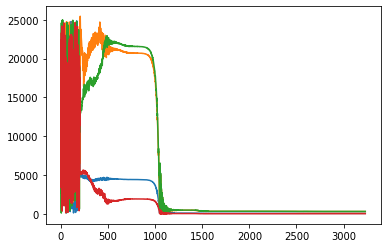

In [122]:
pyplot.plot(tensor(testFitUpscaleAllRes[0]["trajectoryAlphas"]))

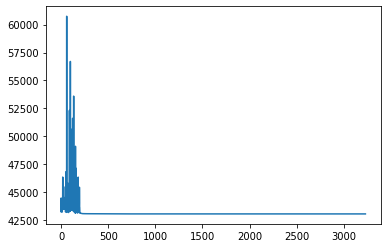

In [108]:
pyplot.plot(tensor(testFitUpscaleAllRes[0]["trajectoryLLs"]))

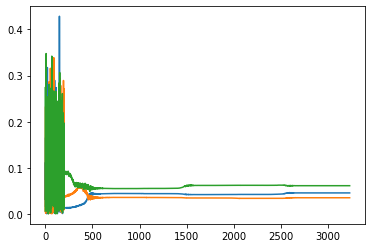

In [109]:
pyplot.plot(tensor(testFitUpscaleAllRes[0]["trajectoryPi"]))

In [110]:
bestLLUpscale = None
bestResIdx = -1
i = 0
for res in testFitUpscale:
    assert(len(res["lls"]) == 1)
    if bestLLUpscale is None or res["lls"][0] < bestLLUpscale:
        bestLLUpscale = res["lls"][0]
        bestResIdx = i
    i += 1
        
testFitUpscale = testFitUpscale[bestResIdx]


In [111]:
print('pis', testFitUpscale["params"][0][:3], 'alphas', testFitUpscale["params"][0][3:])

pis [0.04635838 0.0359028  0.06196038] alphas [ 71.37635762 308.30815557 323.45999316  34.6987948 ]


In [112]:
pdgivenVestimate = likelihoods.inferPDGivenVfromAlphas(tensor(testFitUpscale["params"][0][3:]), pds=pDsUpscale)
pdgivenVestimate

(tensor([0.6590, 0.2282, 0.0528, 0.0599], dtype=torch.float64),
 tensor([0.6523, 0.0524, 0.2361, 0.0591], dtype=torch.float64),
 tensor([0.5069, 0.1950, 0.2033, 0.0948], dtype=torch.float64))

In [123]:
truePDGivenV = likelihoods.empiricalPDGivenV(testDataUpscale["afs"], affectedGenes=testDataUpscale["affectedGenes"],truePV=afMeanUpscale)
truePDGivenV

(tensor([0.6745, 0.2072, 0.0679, 0.0518], dtype=torch.float64),
 tensor([0.6731, 0.0681, 0.2107, 0.0527], dtype=torch.float64),
 tensor([0.4827, 0.2071, 0.2044, 0.1020], dtype=torch.float64))

In [74]:
# from pyro.distributions import Dirichlet
# upscalePisInferred = tensor(testFitUpscale["params"][0][0:3])
# upscaleAlphasInferred = tensor(testFitUpscale["params"][0][3:])
# print("upscalePis", upscalePisInferred, "upscaleAlphas", upscaleAlphasInferred)

In [75]:
# A way to explore power

# # piNullUpscale = 1 - upscalePis.sum()

# likelihoodFnUpscale, nullLikeUpscale, likelihoodFnNoLatentUpscale = likelihoods.effectLikelihood(4, pDs=pDsUpscale, altCountsFlat=testDataUpscale["altCounts"])

# print("null", nullLikeUpscale * (1-upscalePisInferred.sum()))
# affectedGenes1Upscale = tensor(testDataUpscale["affectedGenes"][0])
# affectedGenes2Upscale = tensor(testDataUpscale["affectedGenes"][1])
# affectedGenesBothUpscale = tensor(testDataUpscale["affectedGenes"][2])
# unaffectedGenesUpscale = testDataUpscale["unaffectedGenes"]

# # print(nullLikeUpscale)
# posteriorExpectationEffect = upscalePisInferred * likelihoodFnUpscale(*upscaleAlphasInferred)
# posteriorExpectationNull = (1-upscalePisInferred.sum()) * nullLikeUpscale

# # print("posteriorExpectationOverPDV", posteriorExpectationOverPDV)
# # print("posteriorExpectationOverPD", posteriorExpectationNull)

# likeUpscaleWithNull = torch.stack([posteriorExpectationNull, posteriorExpectationEffect[:,0], posteriorExpectationEffect[:,1], posteriorExpectationEffect[:,2]]).T
# print("likeUpscaleWithNull", likeUpscaleWithNull[0:100])
# print(testDataUpscale["altCounts"][0:100])

# valuesUpscale, indicesUpscale = torch.max(likeUpscaleWithNull[affectedGenes1Upscale],1)
# maskUpscale = indicesUpscale != 1
# badIndicesUpscale = torch.nonzero(maskUpscale)
# maskGoodUpscale = indicesUpscale == 1
# goodIndicesUpscale = torch.nonzero(maskGoodUpscale)
# # print("n misclassified:", badIndicesUpscale.shape, "out of", affectedGenes1Upscale.shape, "n genes", "fraction bad: ", len(badIndicesUpscale)/len(affectedGenes1Upscale))
# print("%Correctly classfieid genes affecting 1:", len(goodIndicesUpscale) * 100/len(affectedGenes1Upscale))

# numRight1orBoth = 0
# for idx in indicesUpscale:
#     if idx == 1 or idx == 3:
#         numRight1orBoth += 1
        
# # goodIndicesUpscaleAssumedNull = torch.nonzero(maskUpsacelAssumedNull)
# print("%Correct classfieid genes affecting 1 if we call correct H1 or HBoth:", numRight1orBoth * 100/len(affectedGenes1Upscale))
# # maskUpscale

# numRightAnyAlternateHypothesis = 0
# for idx in indicesUpscale:
#     if idx != 0:
#         numRightAnyAlternateHypothesis += 1
        
# # goodIndicesUpscaleAssumedNull = torch.nonzero(maskUpsacelAssumedNull)
# print("%Correct classfieid genes affecting 1 if we call correct non-H0 (likelihood max):", numRightAnyAlternateHypothesis * 100/len(affectedGenes1Upscale))
# # maskUpscale

# valuesUpscale, indicesUpscale = torch.max(likeUpscaleWithNull[affectedGenes2Upscale],1)
# maskUpscale = indicesUpscale != 2
# badIndicesUpscale = torch.nonzero(maskUpscale)
# maskGoodUpscale = indicesUpscale == 2
# goodIndicesUpscale = torch.nonzero(maskGoodUpscale)
# # print("n misclassified:", badIndicesUpscale.shape, "out of", affectedGenes1Upscale.shape, "n genes", "fraction bad: ", len(badIndicesUpscale)/len(affectedGenes1Upscale))
# print("%Correctly classfieid risk genes 2:", len(goodIndicesUpscale) * 100/len(affectedGenes2Upscale))
# maskArgmaxUpscale = indicesUpscale != 0
# goodIndicesUpscale = torch.nonzero(maskArgmaxUpscale)
# # print("n misclassified:", badIndicesUpscale.shape, "out of", affectedGenes1Upscale.shape, "n genes", "fraction bad: ", len(badIndicesUpscale)/len(affectedGenes1Upscale))
# print("%Correctly classfieid risk genes 2 using argmax:", len(goodIndicesUpscale) * 100/len(affectedGenes2Upscale))


In [97]:
testDataUpscale["altCounts"]

tensor([[46.,  7.,  2.,  1.],
        [34., 18.,  1.,  4.],
        [52.,  7.,  1.,  1.],
        ...,
        [53.,  0.,  5.,  0.],
        [52.,  7.,  4.,  0.],
        [41.,  4.,  5.,  2.]], dtype=torch.float64)

Params: tensor([ 71.3764, 308.3082, 323.4600,  34.6988], dtype=torch.float64) tensor([0.0464, 0.0359, 0.0620], dtype=torch.float64) tensor([4000., 4000., 1000.]) tensor(50000.) tensor(1.0000e-04) tensor([0.0678, 0.0678, 0.0169]) tensor([50000])
pDS are tensor([0.8475, 0.0678, 0.0678, 0.0169], dtype=torch.float64)
altCounts are tensor([[3., 1., 1., 0.],
        [4., 1., 0., 0.],
        [3., 2., 0., 0.],
        ...,
        [4., 1., 0., 0.],
        [4., 0., 1., 0.],
        [5., 0., 0., 0.]])
pDS are tensor([0.8475, 0.0678, 0.0678, 0.0169])
altCounts are tensor([[3., 1., 1., 0.],
        [4., 1., 0., 0.],
        [3., 2., 0., 0.],
        ...,
        [4., 1., 0., 0.],
        [4., 0., 1., 0.],
        [5., 0., 0., 0.]])
pDS are tensor([0.8475, 0.0678, 0.0678, 0.0169], dtype=torch.float64)
altCounts are tensor([[4., 1., 0., 0.],
        [6., 1., 0., 0.],
        [2., 1., 2., 0.],
        ...,
        [5., 0., 1., 0.],
        [5., 0., 0., 0.],
        [6., 0., 0., 0.]], dtype=torch.fl

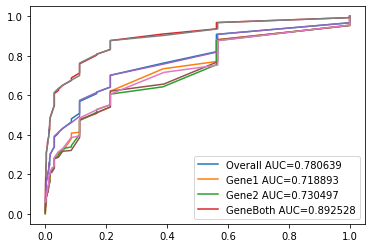

In [155]:
bayes.aucROC(testFitUpscale, testDataUpscale, paramsUpscale, "test-full-posterior.png")


Params: tensor([ 71.3764, 308.3082, 323.4600,  34.6988], dtype=torch.float64) tensor([0.2500, 0.2500, 0.2500]) tensor([4000., 4000., 1000.]) tensor(50000.) tensor(1.0000e-04) tensor([0.0678, 0.0678, 0.0169]) tensor([50000])
pDS are tensor([0.8475, 0.0678, 0.0678, 0.0169], dtype=torch.float64)
altCounts are tensor([[5., 0., 0., 0.],
        [5., 0., 0., 0.],
        [4., 0., 1., 0.],
        ...,
        [5., 0., 0., 0.],
        [5., 0., 0., 0.],
        [4., 1., 0., 0.]])
pDS are tensor([0.8475, 0.0678, 0.0678, 0.0169])
altCounts are tensor([[5., 0., 0., 0.],
        [5., 0., 0., 0.],
        [4., 0., 1., 0.],
        ...,
        [5., 0., 0., 0.],
        [5., 0., 0., 0.],
        [4., 1., 0., 0.]])
pDS are tensor([0.8475, 0.0678, 0.0678, 0.0169], dtype=torch.float64)
altCounts are tensor([[4., 1., 0., 0.],
        [6., 1., 0., 0.],
        [2., 1., 2., 0.],
        ...,
        [5., 0., 1., 0.],
        [5., 0., 0., 0.],
        [6., 0., 0., 0.]], dtype=torch.float64)
pDS are tensor

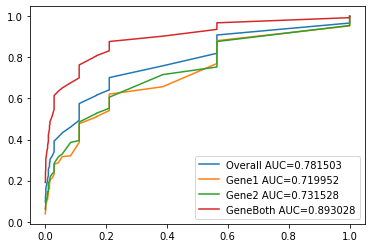

In [156]:
bayes.aucROCflatPrior(testFitUpscale, testDataUpscale, paramsUpscale, "test-flat-prior.png")

In [131]:
# with the exact right pis
bfdpNull, altCountsNullBfPerm = bayes.bfNullGenePosterior(getAlphas(testFitUpscale), paramsUpscale["diseaseFractions"], nIterations=tensor([50_000]), **paramsUpscale)
bfdpData = bayes.bfdp(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=getAlphas(testFitUpscale), pis=paramsUpscale["diseaseFractions"], )

bayes.genAucRocRiskGene(bfdpNull, bfdpData, affectedGenes1=tensor(testDataUpscale["affectedGenes"][0]), affectedGenes2=tensor(testDataUpscale["affectedGenes"][1]), affectedGenesBoth=tensor(testDataUpscale["affectedGenes"][2]), name='test-full-posterior-with-exact-prior.png')
print("real vs null genes1")
print(testDataUpscale["altCounts"][testDataUpscale["affectedGenes"][0]].mean(0))
print(altCountsNullBfPerm[testDataUpscale["affectedGenes"][0]].mean(0))
print("real vs null genes2")
print(testDataUpscale["altCounts"][testDataUpscale["affectedGenes"][1]].mean(0))
print(altCountsNullBfPerm[testDataUpscale["affectedGenes"][1]].mean(0))
print("real vs null genes2")
print(testDataUpscale["altCounts"][testDataUpscale["affectedGenes"][2]].mean(0))
print(altCountsNullBfPerm[testDataUpscale["affectedGenes"][2]].mean(0))
print(len(testDataUpscale["affectedGenes"]))




NameError: name 'testFitUpscale' is not defined

In [117]:
bfdpDataH1 = bayes.bfdpOneAltHypothesis(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=tensor(testFitUpscale["params"][0][3:]), pis=paramsUpscale["diseaseFractions"], )
bfdpDataH1Threshold = bfdpThreshold2

altCounts torch.Size([20000, 4])
pDS are tensor([0.8475, 0.0678, 0.0678, 0.0169], dtype=torch.float64)
altCounts are tensor([[4., 1., 0., 0.],
        [6., 1., 0., 0.],
        [2., 1., 2., 0.],
        ...,
        [5., 0., 1., 0.],
        [5., 0., 0., 0.],
        [6., 0., 0., 0.]], dtype=torch.float64)
pDS are tensor([0.8475, 0.0678, 0.0678, 0.0169])
altCounts are tensor([[4., 1., 0., 0.],
        [6., 1., 0., 0.],
        [2., 1., 2., 0.],
        ...,
        [5., 0., 1., 0.],
        [5., 0., 0., 0.],
        [6., 0., 0., 0.]], dtype=torch.float64)
effectLikes torch.Size([20000, 3])


NameError: name 'bfdpThreshold2' is not defined

In [ ]:
paramsUpscale

In [ ]:
nullCountsUpscale, nullPupscale = bayes.genNullData(getAlphas(testFitUpscale), getPis(testFitUpscale), nIterations=tensor([20_000]), **paramsUpscale)
print(nullCountsUpscale.size())
print(nullPupscale)

In [ ]:
paramsUpscale

In [125]:
bfdpAltH1NullUpscale = bayes.bfdpOneAltHypothesis(altCounts=nullCountsUpscale, pDs=paramsUpscale["pDs"], alphas=getAlphas(testFitUpscale), pis=getPis(testFitUpscale), hIdx=0)
bfdpAlt1H1UpscaleNeeded, fdrH1upscale = bayes.bfdpThreshold2(bfdpAltH1NullUpscale, getAlphas(testFitUpscale), getPis(testFitUpscale), targetFDR=.1, nIterations=tensor([50_000]), **paramsUpscale)
print(bfdpAlt1H1UpscaleNeeded)
print(fdrH1upscale)


altCounts torch.Size([20000, 4])
pDS are tensor([0.8475, 0.0678, 0.0678, 0.0169], dtype=torch.float64)
altCounts are tensor([[2., 0., 3., 0.],
        [4., 1., 0., 0.],
        [5., 0., 0., 0.],
        ...,
        [5., 0., 0., 0.],
        [5., 0., 0., 0.],
        [5., 0., 0., 0.]])
pDS are tensor([0.8475, 0.0678, 0.0678, 0.0169])
altCounts are tensor([[2., 0., 3., 0.],
        [4., 1., 0., 0.],
        [5., 0., 0., 0.],
        ...,
        [5., 0., 0., 0.],
        [5., 0., 0., 0.],
        [5., 0., 0., 0.]])
effectLikes torch.Size([20000, 3])


KeyboardInterrupt: 

In [ ]:
likelihoodFn, nullLikes, likelihoodFnSimpleNoLatent = bayes.effectLikelihood(4, pDs=paramsUpscale["pDs"], altCountsFlat=testDataUpscale["altCounts"])
effectLikesUpscale = likelihoodFn(*getAlphas(testFitUpscale))
print("right model", effectLikesUpscale[testDataUpscale["affectedGenes"][2]].mean(0))
effectLikesSimpleUpscale = likelihoodFnSimpleNoLatent(*getAlphas(testFitUpscale))
print("simple model", effectLikesSimpleUpscale[testDataUpscale["affectedGenes"][2]].mean(0))

bfdpAltH1NullUpscale = bayes.bfdpOneAltHypothesis(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=getAlphas(testFitUpscale), pis=getPis(testFitUpscale), hIdx=0)
print("len", len(bfdpAltH1NullUpscale))
bfdpAltH2NullUpscale = bayes.bfdpOneAltHypothesis(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=getAlphas(testFitUpscale), pis=getPis(testFitUpscale), hIdx=1)
bfdpAltHBothNullUpscale = bayes.bfdpOneAltHypothesis(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=getAlphas(testFitUpscale), pis=getPis(testFitUpscale), hIdx=2)

countCorrect = 0
for i in testDataUpscale["affectedGenes"][0]:
    if bfdpAltH1NullUpscale[i] > bfdpAltH2NullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAltHBothNullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAlt1H1UpscaleNeeded:
#         print("good")
        countCorrect += 1
        
print(countCorrect)
print(countCorrect / len(testDataUpscale["affectedGenes"][0]))

countIncorrect = 0
for i in testDataUpscale["affectedGenes"][1]:
    if bfdpAltH1NullUpscale[i] > bfdpAltH2NullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAltHBothNullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAlt1H1UpscaleNeeded:
#         print("good")
        countIncorrect += 1
    
for i in testDataUpscale["affectedGenes"][2]:
    if bfdpAltH1NullUpscale[i] > bfdpAltH2NullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAltHBothNullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAlt1H1UpscaleNeeded:
#         print("good")
        countIncorrect += 1
    
for i in testDataUpscale["unaffectedGenes"]:
    if bfdpAltH1NullUpscale[i] > bfdpAltH2NullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAltHBothNullUpscale[i] and bfdpAltH1NullUpscale[i] > bfdpAlt1H1UpscaleNeeded:
#         print("good")
        countIncorrect += 1
        
print(countCorrect)
print(countCorrect / len(testDataUpscale["affectedGenes"][0]))

print("nIncorrect", countIncorrect, "out of", len(testDataUpscale["affectedGenes"][1]) + len(testDataUpscale["affectedGenes"][2]) + len(testDataUpscale["unaffectedGenes"]))
print(len(testDataUpscale["unaffectedGenes"]))

In [137]:
bfdpNeededH0vsHA, fdr = bayes.bfdpThreshold(alphas=tensor(testFitUpscale["params"][0][3:]), pis=tensor(testFitUpscale["params"][0][:3]),
                    nCases=paramsUpscale["nCases"], nCtrls=paramsUpscale["nCtrls"],
                    afMean=paramsUpscale["afMean"], pDs=paramsUpscale["pDs"],
                    targetFDR=.1)

empirical p 1.12142 0.07936


In [146]:
bfdpNeededH0vsHA

0.8917265609673449

In [138]:
bfdpNeededH0vsHAFlatPrior, fdrFlatPrior = bayes.bfdpThresholdFlatPrior(alphas=tensor(testFitUpscale["params"][0][3:]),
                    nCases=paramsUpscale["nCases"], nCtrls=paramsUpscale["nCtrls"],
                    afMean=paramsUpscale["afMean"], pDs=paramsUpscale["pDs"],
                    targetFDR=.1)

empirical p 7.19702 0.07908


In [141]:
bfdpNeededH0vsHAFlatPrior

0.13894639725886548

In [168]:
#h1 = P(H1|x) = P(X|H1)P(H1) / sum(P(X|H0..3)*P(H0...3))
#h0 = P(H0|x)
# h1/h0 = P(X|H1)P(H1)  / P(X|H0)P(H0)
print(tensor(testDataUpscale["affectedGenes"][0]).min(), tensor(testDataUpscale["affectedGenes"][0]).max())
h0, h1, h2, h3 = bayes.bfdpAlternates(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"],
                                      alphas=tensor(testFitUpscale["params"][0][3:]), pis=tensor(testFitUpscale["params"][0][:3]), nAlternateHypotheses=3)
# print("testing", h0[1000:1200],h1[1000:1200],h2[1000:1200])
print(torch.nonzero(testDataUpscale["altCounts"][0:1000, 1] > 0).size())
print(torch.nonzero((h0[0:2000] >= bfdpNeededH0vsHA)).size())
print(torch.nonzero((h1[0:2000] >= bfdpNeededH0vsHA)).size())
print(torch.nonzero(((h1[0:2000]/h0[0:2000]) >= 1/bfdpNeededH0vsHA)).size())
print(torch.nonzero(((h1[4000:]/h0[4000:]) >= 1/bfdpNeededH0vsHA)).size())
print(torch.nonzero(((h2[2000:4000]/h0[2000:4000]) >= 1/bfdpNeededH0vsHA)).size())
print(torch.nonzero(((h2[4000:]/h0[4000:]) >= 1/bfdpNeededH0vsHA)).size())
print(torch.nonzero(((h0[4000:]) >= bfdpNeededH0vsHA)).size())

nCorrect = 0
for i in testDataUpscale["affectedGenes"][0]:
    if h1[i] > h0[i] and h1[i] > h2[i] and h1[i] > h3[i]:
        nCorrect += 1
    
print("% correct for genes 1: ", nCorrect/len(testDataUpscale["affectedGenes"][0]))

nCorrect2 = 0
for i in testDataUpscale["affectedGenes"][1]:
    if h2[i] > h0[i] and h2[i] > h1[i] and h2[i] > h3[i]:
        nCorrect2 += 1
    
print("% correct for genes 2: ", nCorrect2/len(testDataUpscale["affectedGenes"][1]))

nCorrect3 = 0
for i in testDataUpscale["affectedGenes"][2]:
    if h3[i] > h0[i] and h3[i] > h2[i] and h3[i] > h1[i]:
        nCorrect3 += 1
    
print("% correct for genes 3: ", nCorrect3/len(testDataUpscale["affectedGenes"][2]))

tensor(0) tensor(1999)
effects tensor([[1.7922e-02, 5.0395e-04, 1.4126e-04],
        [1.3913e-02, 3.9553e-04, 5.7278e-05],
        [1.8007e-03, 1.6851e-06, 7.6438e-05],
        ...,
        [7.4092e-03, 1.1750e-03, 1.9853e-05],
        [1.0811e-02, 1.6989e-03, 4.9769e-05],
        [8.6179e-03, 1.3617e-03, 2.8672e-05]], dtype=torch.float64) 
effects[:, 0].shape:  torch.Size([20000])
denom tensor([0.1530, 0.1582, 0.0021,  ..., 0.4348, 0.4889, 0.4556],
       dtype=torch.float64) 
denom.shape: torch.Size([20000])
h0, h1, h2, h3
 tensor([0.8787, 0.9092, 0.0890,  ..., 0.9802, 0.9743, 0.9780],
       dtype=torch.float64) 
 tensor([0.1171, 0.0880, 0.8731,  ..., 0.0170, 0.0221, 0.0189],
       dtype=torch.float64) 
 tensor([0.0033, 0.0025, 0.0008,  ..., 0.0027, 0.0035, 0.0030],
       dtype=torch.float64) 
 tensor([9.2305e-04, 3.6211e-04, 3.7062e-02,  ..., 4.5659e-05, 1.0180e-04,
        6.2932e-05], dtype=torch.float64)
effects[:, 0] / null tensor([0.1333, 0.0967, 9.8113,  ..., 0.0174, 0.0227

In [169]:
h0, h1, h2, h3 = bayes.bfdpAlternatesFlatPrior(altCounts=testDataUpscale["altCounts"], pDs=paramsUpscale["pDs"], alphas=tensor(testFitUpscale["params"][0][3:]), nAlternateHypotheses=3)

print(torch.nonzero(testDataUpscale["altCounts"][0:1000, 1] > 0).size())
print(torch.nonzero((h0[0:2000] >= bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero((h1[0:2000] >= bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero((h0[1000:2000] >= bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h1[0:1000]/h0[0:1000]) >= 1/bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h1[4000:]/h0[4000:]) >= 1/bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h1[4000:]/h0[4000:]) >= 1/bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h2[1000:2000]/h0[1000:2000]) >= 1/bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h2[4000:]/h0[4000:]) >= 1/bfdpNeededH0vsHAFlatPrior)).size())
print(torch.nonzero(((h0[4000:]) >= bfdpNeededH0vsHAFlatPrior)).size())

nCorrect = 0
for i in testDataUpscale["affectedGenes"][0]:
    if h1[i] > h0[i] and h1[i] > h2[i] and h1[i] > h3[i]:
        nCorrect += 1
    
print("% correct for genes 1: ", nCorrect/len(testDataUpscale["affectedGenes"][0]))

nCorrect2 = 0
for i in testDataUpscale["affectedGenes"][1]:
    if h2[i] > h0[i] and h2[i] > h1[i] and h2[i] > h3[i]:
        nCorrect2 += 1
    
print("% correct for genes 2: ", nCorrect2/len(testDataUpscale["affectedGenes"][1]))

nCorrect3 = 0
for i in testDataUpscale["affectedGenes"][2]:
    if h3[i] > h0[i] and h3[i] > h2[i] and h3[i] > h1[i]:
        nCorrect3 += 1
    
print("% correct for genes 3: ", nCorrect3/len(testDataUpscale["affectedGenes"][2]))

effects tensor([[4.9826e-02, 9.3834e-03, 4.1053e-03],
        [3.8681e-02, 7.3646e-03, 1.6646e-03],
        [5.0064e-03, 3.1376e-05, 2.2215e-03],
        ...,
        [2.0599e-02, 2.1877e-02, 5.7697e-04],
        [3.0056e-02, 3.1632e-02, 1.4464e-03],
        [2.3959e-02, 2.5353e-02, 8.3329e-04]], dtype=torch.float64) 
effects[:, 0].shape:  torch.Size([20000])
denom tensor([0.1012, 0.0882, 0.0073,  ..., 0.1630, 0.1972, 0.1756],
       dtype=torch.float64) 
denom.shape: torch.Size([20000])
h0, h1, h2, h3
 tensor([0.3742, 0.4590, 0.0071,  ..., 0.7359, 0.6799, 0.7144],
       dtype=torch.float64) 
 tensor([0.4925, 0.4386, 0.6848,  ..., 0.1263, 0.1524, 0.1365],
       dtype=torch.float64) 
 tensor([0.0927, 0.0835, 0.0043,  ..., 0.1342, 0.1604, 0.1444],
       dtype=torch.float64) 
 tensor([0.0406, 0.0189, 0.3039,  ..., 0.0035, 0.0073, 0.0047],
       dtype=torch.float64)
effects[:, 0] / null tensor([ 1.3163,  0.9554, 96.8936,  ...,  0.1717,  0.2241,  0.1910],
       dtype=torch.float64)
tor

In [112]:
# upscaleFDRs = bayes.bayesFDRs(bfsUpscaled, upscalePis)
# fdr1 = upscaleFDRs[0]
# maxIdx = torch.nonzero(fdr1 <= .1)[-1]
# minFDR1 = bfsUpscaled[:,0][maxIdx]
# print("min BF at FDR <= .1 for genes1 is", minFDR1)
# minFDR2 = bfsUpscaled[:,1][maxIdx]
# print("min BF at FDR <= .1 for genes2 is", minFDR2)
# upscaleAffected1 = testDataUpscale["affectedGenes"][0]

# upscaleAffected2 = testDataUpscale["affectedGenes"][1]
# upscaleAffectedBoth = testDataUpscale["affectedGenes"][2]

# upscaleUnaffected = testDataUpscale["unaffectedGenes"]

# print(len(upscaleAffected1))
# print("power 1", len(torch.nonzero(bfsUpscaled[upscaleAffected1,0] >= minFDR1)) / len(upscaleAffected1))

# bfs1 = bfsUpscaled[upscaleAffected1]
# bfs2 = bfsUpscaled[upscaleAffected2]
# bfsBoth = bfsUpscaled[upscaleAffectedBoth]

# print("correctly id'd genes 1 compared to 2:", len(torch.nonzero(bfs1[:,0] >= bfs1[:,1])))
# print("correctly id'd genes 1 compared to Both:", len(torch.nonzero(bfs1[:,0] >= bfs1[:,2])))
# print("correctly id'd genes 2 compared to 1:", len(torch.nonzero(bfs2[:,1] >= bfs2[:,0])))
# print("correctly id'd genes 2 compared to Both:", len(torch.nonzero(bfs2[:,1] >= bfs2[:,2])))
# print("correctly id'd genes Both using comparison to component 2:", len(torch.nonzero(bfsBoth[:,2] >= bfsBoth[:,1])))
# print("correctly id'd  genes Both using comparison to component 1:", len(torch.nonzero(bfsBoth[:,2] >= bfsBoth[:,0])))


# bfThreshold = 4
# print(upscaleUnaffected[0])
# falseDiscoveries = torch.nonzero(bfsUpscaled[upscaleUnaffected[1:]].max(1).values > bfThreshold)
# print(bfsUpscaled[upscaleUnaffected[1:]].max(1).values.numpy())
# print(f"false discovery % at threshold {bfThreshold}:", len(falseDiscoveries) * 100 / len(upscaleUnaffected), "%")
# print("correctly id'd genes 1 using fdr threshold and argmax criteria:", len(torch.nonzero(bfs1.max(1).values >= 4)))
# print("correctly id'd genes 1 using fdr threshold:", len(torch.nonzero(bfs1[:, 0] >= 4)))
# print(bfs1[:].max(0))

In [ ]:
# print(bfsUpscaled)
# upscaleFDRs = bayes.bayesFDRsHA(bfsUpscaled, upscalePis)
# fdrUpscale = upscaleFDRs[0]
# print("fdrUpscale",fdrUpscale)
# m = bfsHAupscaled[affectedGenes1Upscale] <= 1.3471
# print("at threshold, num wrong:", len(torch.nonzero(m)))
# print("fdrs", upscaleFDRs)
# print("vs bfs", bfsUpscaled.max(1))

In [ ]:
bfdp = bayes.bfdp(testDataUpscale["altCounts"], pDsUpscale, upscaleAlphas, upscalePis)
print(torch.sort(bfdp))

In [ ]:
bayes.bfdpFDR(1/bfdp)[0:1000]

In [ ]:
# pDsNaturalUpscale = nCasesUpscale/(nCasesUpscale.sum() + nCtrlsUpscale)
# print("natural PDS", pDsNaturalUpscale)

# # changed PDS for classification, on the same data
# testNaturalPDsPostHoc = bayes.bfdp(testDataUpscale["altCounts"], pDsNaturalUpscale, upscaleAlphas, upscalePis)
# print(testNaturalPDsPostHoc[0:1000].mean() /testPDsSpecified[:1000].mean() )

In [ ]:
print(bfPermuted[-tensor(upscaleAffected1)].min(0))
# print(testDataUpscale["altCounts"][upscaleAffected1])

In [ ]:
altCountsPermuted[0:100]

In [ ]:
def fuckyou():
    rrsUpscale = tensor([3, 3, 3])
    pisUpscale = tensor([.05, .05, .05])
    pDsUpscale = tensor([0.0100, 0.0100, 0.0020])
    nCasesUpscale = tensor([1e4, 1e4, 4e3])
    nCtrlsUpscale = tensor(3e5)
    afMeanUpscale = 1e-4
    covSharedUpscale = tensor([[1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]])
    covSingleUpscale = tensor([[1, 0],
            [0, 1]])

    generatingFn =  genData.v6normal
    fitMethod = 'nelder-mead'
    nEpochs=1
    mt = True

    try:
        paramsUpscale = genData.genParams(rrMeans=rrsUpscale, pis=pisUpscale, afMean=afMeanUpscale, rrShape=rrShape, afShape=afShape, nCases=nCasesUpscale, nCtrls=nCtrlsUpscale, pDs=pDsUpscale, covShared=covSharedUpscale, covSingle=covSingleUpscale)[0]
        testDataUpscale = generatingFn(**paramsUpscale)
    except Exception as e:
        print(f"Run failed: {e}")
        
    return paramsUpscale, testDataUpscale



In [ ]:
testDataUpscale["altCounts"][1000:2000,].mean(0)

In [ ]:
paramsTest, dataTest = fuckyou()

In [ ]:
# res = likelihoods.fitFnBivariateMT(dataTest["altCounts"], paramsTest["pDs"], nEpochs=6, minLLThresholdCount=20,
#                                debug=True, costFnIdx=0, method="nelder-mead")

# # The resulting alphas all result in nearly identical P(D|V)'s, despite their values varying widely

# likelihoods.inferPDGivenVfromAlphas(tensor([3.80092715e+05,
#        1.35456865e+06, 1.29957471e+06, 1.53680754e-02]), paramsTest["pDs"])

# likelihoods.inferPDGivenVfromAlphas(tensor([2.67938811e+03,
#        9.57628540e+03, 8.97201393e+03, 1.85012579e-06]), paramsTest["pDs"])

# likelihoods.inferPDGivenVfromAlphas(tensor([8.63042482e+04,
#        3.07577821e+05, 2.94975476e+05, 3.57237298e-03]), paramsTest["pDs"])

# likelihoods.inferPDGivenVfromAlphas(tensor([6.21176683e+05,
#        2.21534588e+06, 2.12392770e+06, 7.27165080e-01]), paramsTest["pDs"])

In [163]:
# For now only 1 set 
assert(len(paramsRuns) == 1)
inferredPis = []
inferredAlphas = []
inferredPDVs = []
truePDVs = []

for paramIdx in range(len(paramsRuns)):
    # inferredPis = []
    # inferredAlphas = []
    # inferredPDVs = []
    # truePDVs = []

    for run in resRuns[paramIdx]["runs"]:
        dataRun = run
        inferredRun = run["results"]["allRes"]
        print(inferredRun)
        inferredPis.append(inferredRun["params"][0][0:3])
        inferredAlphas.append(inferredRun["params"][0][3:])
        print(inferredRun["params"][3:])
        inferredPDV, _, truePDV = likelihoods.trueVsEst(inferredRun, dataRun, paramsRuns[paramIdx])
        print(truePDVs)
        truePDVs.append(truePDV)
        inferredPDVs.append(inferredPDV)

# # plt.subplot([1,len(resByParams)])
# i = 0
# with open("mvln-sim-mvln-res.tsv", "w") as file:
#     file.write(f"Notes: 15000 samples1, 15000 samples2, 6000 samplesBoth; rrs generated from normal distribution with. 1 variance, .4 covariance, and individual effect rr summed with shared-effect rr in genes affecting both conditions\n")
#     file.write(f"\tmean\tstd\n")
#     for res in resByParams:
#         i += 1

#         paramsRun = res[0]
#         resRun = res[1]

#         pis = tensor([x["bestRes"]["pis"].numpy() for x in resRun])
#         PDV_c1true = tensor([x["bestRes"]["PDV_c1true"].numpy() for x in resRun])
#         PDV_c2true = tensor([x["bestRes"]["PDV_c2true"].numpy() for x in resRun])
#         PDV_c3true = tensor([x["bestRes"]["PDV_cBothTrue"].numpy() for x in resRun])
#         PDV_c1inferred = tensor([x["bestRes"]["PDV_c1inferred"].numpy() for x in resRun])
#         PDV_c2inferred = tensor([x["bestRes"]["PDV_c2inferred"].numpy() for x in resRun])
#         PDV_c3inferred = tensor([x["bestRes"]["PDV_cBothInferred"].numpy() for x in resRun])

#         file.write(f"\n\ntrue params: \t{paramsRun} \n\n")

#         file.write(f"pi\t {pis.mean(0).numpy()} \t  {pis.std(0).numpy()} \n")

#         file.write(f"PDV_c1inferred \t {PDV_c1inferred.mean(0).numpy()}\t {PDV_c1inferred.std(0).numpy()}\n")
#         file.write(f"PDV_c1true \t {PDV_c1true.mean(0).numpy()} \t {PDV_c1true.std(0).numpy()}\n")
#         file.write(f"PDV_c2inferred \t {PDV_c2inferred.mean(0).numpy()} \t {PDV_c2inferred.std(0).numpy()}\n")
        
#         file.write(f"PDV_c2true \t {PDV_c2true.mean(0).numpy()} \t {PDV_c2true.std(0).numpy()}\n")
        
#         file.write(f"PDV_c3inferred \t {PDV_c3inferred.mean(0).numpy()} \t {PDV_c3inferred.std(0).numpy()}\n")
        
#         file.write(f"PDV_c3true \t {PDV_c3true.mean(0).numpy()} \t {PDV_c3true.std(0).numpy()}\n")

#     #     plt.figure(i)
#     #     plt.plot(t, s1)
#     #     plt.plot(t, 2*s1)
#         # plt.subplot(222)
#         # plt.plot(t, 2*s1)

inferredPis = tensor(inferredPis)
inferredAlphas = tensor(inferredAlphas)
inferredPDVs = tensor(inferredPDVs)
truePDVs = tensor(truePDVs)

 'llsAll': [39561.37255098566], 'params': [array([1.11958400e-01, 3.01364741e-02, 3.38886007e-02, 6.35670018e+02,
       1.79606332e+03, 1.83322542e+03, 8.27375144e+02])]}
[]
[0.95692609 0.02764582 0.00978452 0.00564357]
est pis: [0.1119584  0.03013647 0.0338886 ]
tru pis: tensor([0.1000, 0.0500, 0.0200])


Estimate for component: 0
est: P(D|V) [0.95692609 0.02764582 0.00978452 0.00564357] variance: [6.33479413e-05 4.13136714e-05 1.48904938e-05 8.62453414e-06] alphas: [0.95692609 0.02764582 0.00978452 0.00564357]
tru: P(D|V) [1.1093123  0.03648355 0.0116474  0.00729671] alphas: [1.1093123  0.03648355 0.0116474  0.00729671]


Estimate for component: 1
est: P(D|V) [0.95637903 0.00977893 0.0282017  0.00564034] variance: [6.40792242e-05 1.48735703e-05 4.20962435e-05 8.61471138e-06] alphas: [0.95637903 0.00977893 0.0282017  0.00564034]
tru: P(D|V) [1.0253063  0.01072317 0.03023921 0.00604784] alphas: [1.0253063  0.01072317 0.03023921 0.00604784]


Estimate for component: 2
est: P(D|V) [0.90

In [162]:
resRuns =    np.load("/Users/alexkotlar/projects/tada/rr3,3,1_5_gamma_15kcases_2020-08-111597157068/results_list.npy", allow_pickle=True)
paramsRuns = np.load("/Users/alexkotlar/projects/tada/rr3,3,1_5_gamma_15kcases_2020-08-111597157068/params_list.npy", allow_pickle=True)
dataRun0 = res[0]["runs"][0]
inferredRun0 = res[0]["runs"][0]["results"]["allRes"]
# params1 = 
# params[0]

likelihoods.trueVsEst(inferredRun0, dataRun0, paramsRuns[0])
# dataRuns.keys()
paramsRuns

[0.95364573 0.03087217 0.00975098 0.00573112]
est pis: [0.08971493 0.06783958 0.01683534]
tru pis: tensor([0.1000, 0.0500, 0.0200])


Estimate for component: 0
est: P(D|V) [0.95364573 0.03087217 0.00975098 0.00573112] variance: [8.62184374e-06 5.83541250e-06 1.88328469e-06 1.11139061e-06] alphas: [0.95364573 0.03087217 0.00975098 0.00573112]
tru: P(D|V) [1.1190876  0.03934724 0.01178085 0.00786945] alphas: [1.1190876  0.03934724 0.01178085 0.00786945]


Estimate for component: 1
est: P(D|V) [0.95576425 0.00977264 0.02871926 0.00574385] variance: [8.26439475e-06 1.89161919e-06 5.45261541e-06 1.11631921e-06] alphas: [0.95576425 0.00977264 0.02871926 0.00574385]
tru: P(D|V) [0.88884616 0.00932224 0.02837925 0.00567585] alphas: [0.88884616 0.00932224 0.02837925 0.00567585]


Estimate for component: 2
est: P(D|V) [0.88943331 0.04876763 0.04670031 0.01509875] variance: [1.78892888e-05 8.43866310e-06 8.09850016e-06 2.70513571e-06] alphas: [0.88943331 0.04876763 0.04670031 0.01509875]
tru: P(D

array([{'nGenes': 20000, 'nCases': tensor([15000., 15000.,  6000.]), 'nCtrls': tensor(300000.), 'pDs': tensor([0.0100, 0.0100, 0.0020]), 'diseaseFractions': tensor([0.1000, 0.0500, 0.0200]), 'rrShape': tensor(50.), 'rrMeans': tensor([3.0000, 3.0000, 1.5000]), 'afShape': tensor(50.), 'afMean': 0.0001, 'covShared': tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]), 'covSingle': tensor([[1, 0],
        [0, 1]])}], dtype=object)

In [164]:
print("inferredPDVs")
print(inferredPDVs.mean(0))
print("truePDVs")
print(truePDVs.mean(0))
print("truePDVs std")
print(truePDVs.std(0))
print("inferredPDVs std")
print(inferredPDVs.std(0))

inferredPDVs
tensor([[0.9541, 0.0300, 0.0098, 0.0062],
        [0.9533, 0.0097, 0.0308, 0.0062],
        [0.8967, 0.0439, 0.0448, 0.0146]], dtype=torch.float64)
truePDVs
tensor([[1.0053, 0.0341, 0.0106, 0.0068],
        [0.9486, 0.0099, 0.0287, 0.0057],
        [0.9192, 0.0464, 0.0477, 0.0156]])
truePDVs std
tensor([[0.1141, 0.0030, 0.0012, 0.0006],
        [0.0974, 0.0010, 0.0041, 0.0008],
        [0.1291, 0.0069, 0.0062, 0.0021]])
inferredPDVs std
tensor([[2.1344e-03, 1.8599e-03, 2.1824e-05, 5.4255e-04],
        [3.1517e-03, 3.2226e-05, 2.6533e-03, 5.3066e-04],
        [8.5768e-03, 4.2268e-03, 3.8853e-03, 8.8314e-04]], dtype=torch.float64)


In [125]:
truePDVs

tensor([[[1.1191, 0.0393, 0.0118, 0.0079],
         [0.8888, 0.0093, 0.0284, 0.0057],
         [0.8914, 0.0461, 0.0402, 0.0143]],

        [[0.9336, 0.0320, 0.0098, 0.0064],
         [1.0052, 0.0105, 0.0281, 0.0056],
         [0.7987, 0.0381, 0.0385, 0.0127]],

        [[1.1093, 0.0365, 0.0116, 0.0073],
         [1.0253, 0.0107, 0.0302, 0.0060],
         [0.7509, 0.0390, 0.0407, 0.0133]],

        [[0.9210, 0.0349, 0.0097, 0.0070],
         [1.0514, 0.0110, 0.0305, 0.0061],
         [1.0071, 0.0595, 0.0541, 0.0192]],

        [[0.8029, 0.0289, 0.0085, 0.0058],
         [0.8877, 0.0093, 0.0280, 0.0056],
         [1.1944, 0.0521, 0.0540, 0.0176]],

        [[0.9029, 0.0316, 0.0095, 0.0063],
         [0.9226, 0.0097, 0.0304, 0.0061],
         [0.9524, 0.0459, 0.0528, 0.0159]],

        [[1.1180, 0.0335, 0.0117, 0.0067],
         [1.0806, 0.0114, 0.0364, 0.0073],
         [1.0064, 0.0511, 0.0524, 0.0174]],

        [[1.0274, 0.0326, 0.0108, 0.0065],
         [0.9746, 0.0102, 0.0286, 0.0057

In [196]:
resRuns =    np.load("/Users/alexkotlar/projects/tada/rr1_5,1_5,1_5_gamma_15kcases_2020-08-111597160601/results_list.npy", allow_pickle=True)
paramsRuns = np.load("//Users/alexkotlar/projects/tada/rr1_5,1_5,1_5_gamma_15kcases_2020-08-111597160601/params_list.npy", allow_pickle=True)
dataRun0 = res[0]["runs"][0]
inferredRun0 = res[0]["runs"][0]["results"]["allRes"]
# params1 = 
# params[0]

likelihoods.trueVsEst(inferredRun0, dataRun0, paramsRuns[0])
# dataRuns.keys()
paramsRuns


[0.95364573 0.03087217 0.00975098 0.00573112]
est pis: [0.08971493 0.06783958 0.01683534]
tru pis: tensor([0.1000, 0.0500, 0.0200])


Estimate for component: 0
est: P(D|V) [0.95364573 0.03087217 0.00975098 0.00573112] variance: [8.62184374e-06 5.83541250e-06 1.88328469e-06 1.11139061e-06] alphas: [0.95364573 0.03087217 0.00975098 0.00573112]
tru: P(D|V) [1.1190876  0.03934724 0.01178085 0.00786945] alphas: [1.1190876  0.03934724 0.01178085 0.00786945]


Estimate for component: 1
est: P(D|V) [0.95576425 0.00977264 0.02871926 0.00574385] variance: [8.26439475e-06 1.89161919e-06 5.45261541e-06 1.11631921e-06] alphas: [0.95576425 0.00977264 0.02871926 0.00574385]
tru: P(D|V) [0.88884616 0.00932224 0.02837925 0.00567585] alphas: [0.88884616 0.00932224 0.02837925 0.00567585]


Estimate for component: 2
est: P(D|V) [0.88943331 0.04876763 0.04670031 0.01509875] variance: [1.78892888e-05 8.43866310e-06 8.09850016e-06 2.70513571e-06] alphas: [0.88943331 0.04876763 0.04670031 0.01509875]
tru: P(D

array([{'nGenes': 20000, 'nCases': tensor([15000., 15000.,  6000.]), 'nCtrls': tensor(300000.), 'pDs': tensor([0.0100, 0.0100, 0.0020]), 'diseaseFractions': tensor([0.1000, 0.0500, 0.0200]), 'rrShape': tensor(50.), 'rrMeans': tensor([1.5000, 1.5000, 1.5000]), 'afShape': tensor(50.), 'afMean': 0.0001, 'covShared': tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]), 'covSingle': tensor([[1, 0],
        [0, 1]])}], dtype=object)

In [197]:
# For now only 1 set 
assert(len(paramsRuns) == 1)
inferredPis = []
inferredAlphas = []
inferredPDVs = []
truePDVs = []

for paramIdx in range(len(paramsRuns)):
    # inferredPis = []
    # inferredAlphas = []
    # inferredPDVs = []
    # truePDVs = []

    for run in resRuns[paramIdx]["runs"]:
        dataRun = run
        inferredRun = run["results"]["allRes"]
        print(inferredRun)
        inferredPis.append(inferredRun["params"][0][0:3])
        inferredAlphas.append(inferredRun["params"][0][3:])
        print(inferredRun["params"][3:])
        inferredPDV, _, truePDV = likelihoods.trueVsEst(inferredRun, dataRun, paramsRuns[paramIdx])
        print(truePDVs)
        truePDVs.append(truePDV)
        inferredPDVs.append(inferredPDV)

# # plt.subplot([1,len(resByParams)])
# i = 0
# with open("mvln-sim-mvln-res.tsv", "w") as file:
#     file.write(f"Notes: 15000 samples1, 15000 samples2, 6000 samplesBoth; rrs generated from normal distribution with. 1 variance, .4 covariance, and individual effect rr summed with shared-effect rr in genes affecting both conditions\n")
#     file.write(f"\tmean\tstd\n")
#     for res in resByParams:
#         i += 1

#         paramsRun = res[0]
#         resRun = res[1]

#         pis = tensor([x["bestRes"]["pis"].numpy() for x in resRun])
#         PDV_c1true = tensor([x["bestRes"]["PDV_c1true"].numpy() for x in resRun])
#         PDV_c2true = tensor([x["bestRes"]["PDV_c2true"].numpy() for x in resRun])
#         PDV_c3true = tensor([x["bestRes"]["PDV_cBothTrue"].numpy() for x in resRun])
#         PDV_c1inferred = tensor([x["bestRes"]["PDV_c1inferred"].numpy() for x in resRun])
#         PDV_c2inferred = tensor([x["bestRes"]["PDV_c2inferred"].numpy() for x in resRun])
#         PDV_c3inferred = tensor([x["bestRes"]["PDV_cBothInferred"].numpy() for x in resRun])

#         file.write(f"\n\ntrue params: \t{paramsRun} \n\n")

#         file.write(f"pi\t {pis.mean(0).numpy()} \t  {pis.std(0).numpy()} \n")

#         file.write(f"PDV_c1inferred \t {PDV_c1inferred.mean(0).numpy()}\t {PDV_c1inferred.std(0).numpy()}\n")
#         file.write(f"PDV_c1true \t {PDV_c1true.mean(0).numpy()} \t {PDV_c1true.std(0).numpy()}\n")
#         file.write(f"PDV_c2inferred \t {PDV_c2inferred.mean(0).numpy()} \t {PDV_c2inferred.std(0).numpy()}\n")
        
#         file.write(f"PDV_c2true \t {PDV_c2true.mean(0).numpy()} \t {PDV_c2true.std(0).numpy()}\n")
        
#         file.write(f"PDV_c3inferred \t {PDV_c3inferred.mean(0).numpy()} \t {PDV_c3inferred.std(0).numpy()}\n")
        
#         file.write(f"PDV_c3true \t {PDV_c3true.mean(0).numpy()} \t {PDV_c3true.std(0).numpy()}\n")

#     #     plt.figure(i)
#     #     plt.plot(t, s1)
#     #     plt.plot(t, 2*s1)
#         # plt.subplot(222)
#         # plt.plot(t, 2*s1)

inferredPis = tensor(inferredPis)
inferredAlphas = tensor(inferredAlphas)
inferredPDVs = tensor(inferredPDVs)
truePDVs = tensor(truePDVs)

 0.00895304 0.01001636 0.0014301 ]
est pis: [2.47029885e-10 8.80430926e-02 1.23852969e-01]
tru pis: tensor([0.1000, 0.0500, 0.0200])


Estimate for component: 0
est: P(D|V) [0.9796005  0.00895304 0.01001636 0.0014301 ] variance: [9.81097179e-06 4.35620236e-06 4.86834786e-06 7.01114077e-07] alphas: [0.9796005  0.00895304 0.01001636 0.0014301 ]
tru: P(D|V) [0.9711576  0.01321184 0.00996982 0.00264237] alphas: [0.9711576  0.01321184 0.00996982 0.00264237]


Estimate for component: 1
est: P(D|V) [0.98136945 0.01003445 0.00716342 0.00143268] variance: [8.99259210e-06 4.88585253e-06 3.49803901e-06 7.03646044e-07] alphas: [0.98136945 0.01003445 0.00716342 0.00143268]
tru: P(D|V) [1.0355614  0.01067113 0.01740042 0.00348009] alphas: [1.0355614  0.01067113 0.01740042 0.00348009]


Estimate for component: 2
est: P(D|V) [0.9588164  0.01888551 0.01712122 0.00517686] variance: [1.89755407e-05 8.90395315e-06 8.08666033e-06 2.47483839e-06] alphas: [0.9588164  0.01888551 0.01712122 0.00517686]
tru: P(

In [198]:
# print(inferredAlphas.mean(0))
# print(inferredAlphas.var(0))
print("inferredPDVs")
print(inferredPDVs.mean(0))
print("truePDVs")
print(truePDVs.mean(0))
print("truePDVs std")
print(truePDVs.std(0))
print("inferredPDVs std")
print(inferredPDVs.std(0))
# inferredAlphas
# pyplot.plot(inferredPDVs[:, 0].T)

inferredPDVs
tensor([[0.9784, 0.0096, 0.0100, 0.0019],
        [0.9784, 0.0100, 0.0097, 0.0019],
        [0.9498, 0.0220, 0.0220, 0.0063]], dtype=torch.float64)
truePDVs
tensor([[0.9341, 0.0137, 0.0096, 0.0027],
        [0.9917, 0.0102, 0.0157, 0.0031],
        [0.9299, 0.0312, 0.0310, 0.0093]])
truePDVs std
tensor([[0.1206, 0.0022, 0.0012, 0.0004],
        [0.1012, 0.0010, 0.0013, 0.0003],
        [0.1034, 0.0049, 0.0030, 0.0010]])
inferredPDVs std
tensor([[3.3057e-03, 2.5588e-03, 3.3800e-05, 1.1350e-03],
        [6.6529e-03, 6.8026e-05, 5.6008e-03, 1.1202e-03],
        [1.1474e-02, 3.6682e-03, 6.7321e-03, 1.6490e-03]], dtype=torch.float64)


Params: tensor([ 3722574.8829, 11812879.9930, 12710937.8719,  7379405.2092],
       dtype=torch.float64) tensor([0.0448, 0.0594, 0.0470], dtype=torch.float64) tensor([15000., 15000.,  6000.]) tensor(300000.) 0.0001 tensor([0.0100, 0.0100, 0.0020]) tensor([50000])
pDS are tensor([0.9780, 0.0100, 0.0100, 0.0020], dtype=torch.float64)
altCounts are tensor([[32.,  0.,  1.,  0.],
        [32.,  0.,  1.,  0.],
        [32.,  1.,  0.,  0.],
        ...,
        [33.,  0.,  0.,  0.],
        [33.,  0.,  0.,  0.],
        [33.,  0.,  0.,  0.]])
pDS are tensor([0.9780, 0.0100, 0.0100, 0.0020])
altCounts are tensor([[32.,  0.,  1.,  0.],
        [32.,  0.,  1.,  0.],
        [32.,  1.,  0.,  0.],
        ...,
        [33.,  0.,  0.,  0.],
        [33.,  0.,  0.,  0.],
        [33.,  0.,  0.,  0.]])
pDS are tensor([0.9780, 0.0100, 0.0100, 0.0020], dtype=torch.float64)
altCounts are tensor([[30.,  0.,  0.,  0.],
        [29.,  0.,  0.,  0.],
        [27.,  1.,  1.,  0.],
        ...,
        [41., 

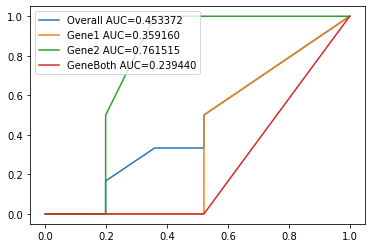

In [199]:
dataRun = resRuns[0]["runs"][0]
inferredRun = resRuns[0]["runs"][0]["results"]["allRes"]
bayes.aucROC(testFit, dataRun, paramsRuns[0], "test-full-posterior.png")

In [170]:
resRuns[0]["runs"][0].keys()

dict_keys(['altCounts', 'afs', 'affectedGenes', 'unaffectedGenes', 'generatingFn', 'results'])

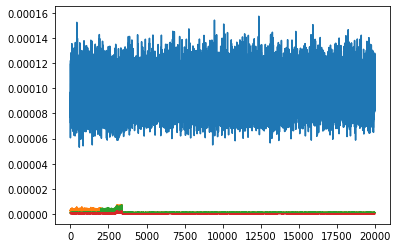

In [184]:
pyplot.plot(dataRun["afs"])

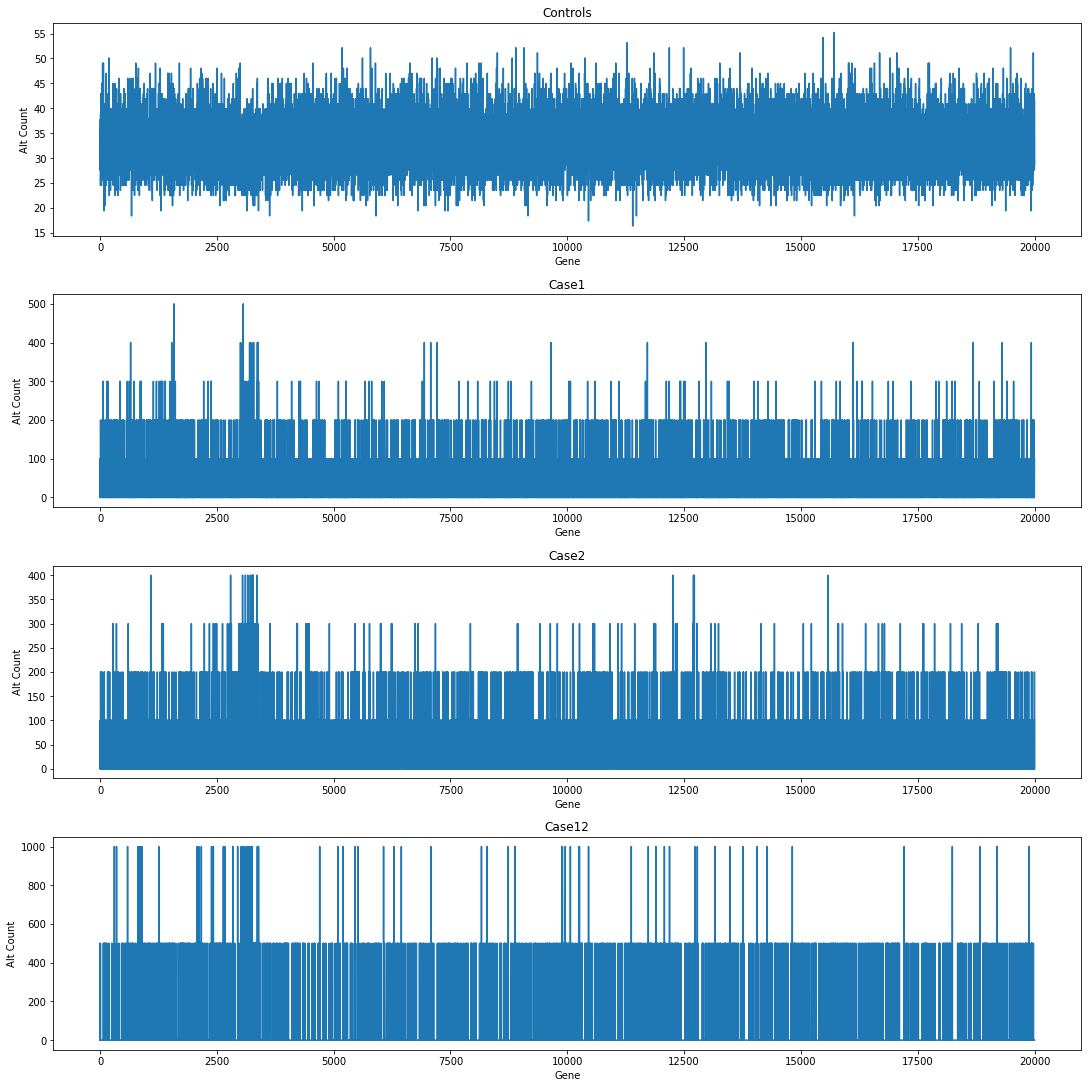

In [258]:
# dataRun["afs"] are P(V|D)*P(D) (and P(V|!D) * P(!D))
# that equals P(D|V)P(V)
# so if we divide that by P(V)
# we get P(D|V)
# and if we divide it by P(D) and P(V) we get rr

pDs = tensor([1- paramsRuns[0]["pDs"].sum(), *paramsRuns[0]["pDs"]])
pDs

scaledAfs = dataRun["altCounts"] / pDs

risk1Genes = scaledAfs[ dataRun["affectedGenes"][0][0]: dataRun["affectedGenes"][0][1] ]
risk2Genes = scaledAfs[ dataRun["affectedGenes"][1][0]: dataRun["affectedGenes"][1][1] ]
risk12Genes = scaledAfs[ dataRun["affectedGenes"][2][0]: dataRun["affectedGenes"][2][1] ]

# assert( np.isclose( risk1Genes.mean(0)[0], 1, rtol = .01) )
# assert( np.isclose( risk1Genes.mean(0)[1], paramsRuns[0]["rrMeans"][0], rtol = .01) )
# assert( np.isclose( risk1Genes.mean(0)[2], 1, rtol = .01) )
# assert( np.isclose( risk1Genes.mean(0)[3], paramsRuns[0]["rrMeans"][0], rtol = .01) )

# assert( np.isclose( risk2Genes.mean(0)[0], 1, rtol = .01) )
# assert( np.isclose( risk2Genes.mean(0)[1], 1, rtol = .01) )
# assert( np.isclose( risk2Genes.mean(0)[2], paramsRuns[0]["rrMeans"][1], rtol = .01) )
# assert( np.isclose( risk2Genes.mean(0)[3], paramsRuns[0]["rrMeans"][1], rtol = .01) )

# # These are somewhat lower: the greater skew in weights betweens categories, due to the simplex constraint?
# # alternatively smaller sample (only 1000 genes vs 2000 in other categories
# assert( np.isclose( risk12Genes.mean(0)[0], 1, rtol = .1) )
# assert( np.isclose( risk12Genes.mean(0)[1], paramsRuns[0]["rrMeans"][0] + paramsRuns[0]["rrMeans"][2], rtol = .1) )
# assert( np.isclose( risk12Genes.mean(0)[2], paramsRuns[0]["rrMeans"][1] + paramsRuns[0]["rrMeans"][2], rtol = .1) )
# assert( np.isclose( risk12Genes.mean(0)[3], paramsRuns[0]["rrMeans"][0] + paramsRuns[0]["rrMeans"][1] + paramsRuns[0]["rrMeans"][2], rtol = .1) )

fig, axs = plt.subplots(4, 1, figsize=(15,15), constrained_layout=True)
axs[0].plot(scaledAfs[:,0])
axs[0].set_title('Controls')
axs[0].set_xlabel('Gene')
axs[0].set_ylabel('Alt Count / P(D)')

axs[1].plot(scaledAfs[:,1])
axs[1].set_title('Case1')
axs[1].set_xlabel('Gene')
axs[1].set_ylabel('Alt Count / P(D)')

axs[2].plot(scaledAfs[:,2])
axs[2].set_title('Case2')
axs[2].set_xlabel('Gene')
axs[2].set_ylabel('Alt Count / P(D)')

axs[3].plot(scaledAfs[:,3])
axs[3].set_title('Case12')
axs[3].set_xlabel('Gene')
axs[3].set_ylabel('Alt Count / P(D)')

plt.show()